In [12]:
import os
import sys
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
import torch
import seaborn as sns
import nibabel as nib
import pickle
import torchvision.models as models
import nibabel as nib
import h5py
import scipy.stats.mstats as mstats
import copy

from nilearn import plotting
from scipy.ndimage import binary_dilation
from PIL import Image
from importlib import reload
from scipy.io import loadmat
from matplotlib.ticker import MultipleLocator
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import r2_score
from colorama import Fore, Style
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.impute import SimpleImputer
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from tqdm import tqdm
from matplotlib.lines import Line2D



os.chdir('/home/rfpred')
sys.path.append('/home/rfpred')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

### Important to distinguish between main Methods and large image files, a lot of these files don't need to be temporarily stored, but just easily accessible

In [2]:
class DataFetch():
    
    def __init__(self, NSPobject):
        self.nsp = NSPobject
        pass
    
    # Function to get the pRF-based voxel selections
    # IMPROVE: make sure that it also works for all subjects later on. Take subject arg, clean up paths.
    def prf_selections(self):
        prf_selection_paths = [
            './data/custom_files/subj01/prf_mask_center_strict.pkl',
            './data/custom_files/subj01/prf_mask_central_strict_l.pkl',
            './data/custom_files/subj01/prf_mask_central_halfloose.pkl',
            './data/custom_files/subj01/prf_mask_central_loose.pkl',
            './data/custom_files/subj01/prf_mask_periphery_strict.pkl'
        ]
        return {os.path.basename(file): self._fetch_file(file) for file in prf_selection_paths}
    
    # General file fetching function 
    def fetch_file(self, file_path:str):
        """
        General function to acquire saved data from various file types
        file_type: str, the types of files to be fetched, either features or prf_selections
        """
        _, ext = os.path.splitext(file_path)
        
        # Check if file is of .h5 type
        if ext == '.h5':
            with h5py.File(file_path, 'r') as hf:
                data = hf.keys()
                return {key: np.array(hf[key]).flatten() for key in data}
        # Check if file is of .pkl type
        elif ext == '.pkl':
            with open(file_path, 'rb') as fp:
                return pickle.load(fp)
            
            
    # Function to load in nifti (.nii.gz) data and create some useful variables 
    def get_dat(self, path:str):
        full_dat = nib.load(path)
        dat_array = full_dat.get_fdata()
        
        # Calculate the range of values
        flat_arr = dat_array[~np.isnan(dat_array)]
        dat_dim = dat_array.shape

        return full_dat, dat_array, dat_dim, {'min': round(np.nanmin(flat_arr),7), 'max': np.nanmax(flat_arr), 'mean': round(np.nanmean(flat_arr),5)}

In [3]:
class Utilities():

    def __init__(self):
        pass
        
    # Utility function to visualize dictionary structures
    def print_dict_structure(self, d, indent=0):
        for key, value in d.items():
            print(' ' * indent + str(key))
            if isinstance(value, dict):
                self.print_dict_structure(value, indent + 4)
                
    def print_large(self, item):
        with np.printoptions(threshold=np.inf):
            print(item)
            
    # Function to create the Gaussian image
    def make_gaussian_2d(self, size, center_row, center_col, sigma):
        rows = np.arange(size)
        cols = np.arange(size)
        rows, cols = np.meshgrid(rows, cols)
        exponent = -((rows - center_row)**2 / (2 * sigma**2) + (cols - center_col)**2 / (2 * sigma**2))
        gaussian = np.exp(exponent)
        return gaussian        
    
    # Function to create a circle mask
    def make_circle_mask(self, size, center_row, center_col, radius, fill='y', margin_width=1):
        rows = np.arange(size)
        cols = np.arange(size)
        rows, cols = np.meshgrid(rows, cols)

        # Calculate the distance from each point to the center
        distances = np.sqrt((rows - center_row)**2 + (cols - center_col)**2)

        # Create a binary mask where values within the radius are set to 1, others to 0
        circle_mask = np.where(distances <= radius, 1, 0)

        # Create a dilated version of the binary mask to add a margin
        dilated_circle_mask = binary_dilation(circle_mask, iterations=margin_width)

        # Subtract the dilated version to create the outline
        outline_circle_mask = circle_mask - dilated_circle_mask

        if fill == 'y':
            return circle_mask
        elif fill == 'n':
            return -outline_circle_mask

    def css_gaussian_cut(self, size, center_row, center_col, sigma):
        rows = np.arange(size)
        cols = np.arange(size)
        rows, cols = np.meshgrid(rows, cols)

        distances = np.sqrt((rows - center_row)**2 + (cols - center_col)**2)
        mask = np.where(distances <= sigma, 1, 0)

        exponent = -((rows - center_row)**2 / (2 * sigma**2) + (cols - center_col)**2 / (2 * sigma**2))
        gaussian = np.exp(exponent)
        gaussian *= mask
        return gaussian

    
    def get_zscore(self, data, print_ars = 'y'):
        mean_value = np.mean(data)
        std_dev = np.std(data)

        # Calculate z-scores
        z_scores = (data - mean_value) / std_dev

        if print_ars == 'y':
            print("Original array:", data)
            print("Z-scores:", z_scores)
            
        return z_scores

    def cap_values(self, array = None, lower_threshold = None, upper_threshold = None):
        
        if upper_threshold is None:
            upper_threshold = np.max(array)
        else:
            # Identify values above the upper threshold
            above_upper_threshold = array > upper_threshold
            
            # Identify the highest value below the upper threshold
            highest_below_upper_threshold = array[array <= upper_threshold].max()

            # Replace values above the upper threshold with the highest value below the upper threshold
            array[above_upper_threshold] = highest_below_upper_threshold

        if lower_threshold is None:
            lower_threshold = np.min(array)
        else:
            # Identify values below the lower threshold
            below_lower_threshold = array < lower_threshold

            # Identify the lowest value above the lower threshold
            lowest_above_lower_threshold = array[array >= lower_threshold].min()

            # Replace values below the lower threshold with the lowest value above the lower threshold
            array[below_lower_threshold] = lowest_above_lower_threshold

        return array

    def mean_center(self, data, print_ars = 'y'):
        mean_value = np.mean(data)

        # Mean centering
        centered_data = data - mean_value

        if print_ars == 'y':
            print("Original array:", data)
            print("Centered data:", centered_data)
            
        return centered_data

    # Function to generate a bell-shaped vector
    def generate_bell_vector(self, n, width, location, kurtosis=0, plot = 'y'):
        x = np.linspace(0, 1, n)
        y = np.exp(-0.5 * ((x - location) / width) ** 2)
        
        if kurtosis != 0:
            y = y ** kurtosis
        
        y /= np.sum(y)  # Normalize the vector to sum up to 1
        
        if plot == 'y':
            plt.scatter(x, y)
            plt.xlabel('Index')
            plt.ylabel('Value')
            plt.title('Bell-Shaped Vector')
            plt.show()
            
        return y

    def calculate_sigma(self, eccentricity, angle, visual_stimulus_size=8.4):
        # Convert polar coordinates to Cartesian coordinates
        x = eccentricity * np.cos(angle)
        y = eccentricity * np.sin(angle)

        # Calculate the scaling factor based on visual stimulus size and eccentricity range
        eccentricity_range = 1000  
        scaling_factor = visual_stimulus_size / eccentricity_range

        # Calculate sigma
        sigma = np.sqrt(x**2 + y**2) * scaling_factor

        return sigma, x, y


    # Function to plot the hypotheses for the feature and unpredictability sensitivity
    def hypotheses_plot(self):

        hypothesis_1 = hypothesis_2 = np.zeros((4, 5))
        for i in range(4):
            loc = i/3
            # generate_bell_vector(5, 0.15, loc)
            hypothesis_1[i, :] = np.array(self.generate_bell_vector(5, 0.0115, loc, 0.01, plot = 'n'))
            
        hypothesis_3 = np.zeros((4, 5))
        for i in range(4):
            loc = i/3
            # generate_bell_vector(5, 0.15, loc)
            hypothesis_3[np.abs(i - 3), :] = np.array(self.generate_bell_vector(5, 0.0115, loc, 0.01, plot = 'n'))
            
        # Keeping the same values for Hypothesis 4
        hypothesis_4 = np.zeros((4, 5))
        for i in range(4):
            hypothesis_4[i, :] = hypothesis_1[3]

        hypotheses = [hypothesis_1, hypothesis_2, hypothesis_3, hypothesis_4]

        # Visual areas
        visual_areas = ['V1', 'V2', 'V3', 'V4']

        # Define a gradient colormap from dark blue to light red
        cmap = LinearSegmentedColormap.from_list('NavyBlueVeryLightGreyDarkRed', ['#000080', '#CCCCCC', '#FFA500', '#FF0000'], N=5)

        # Plotting
        fig, axs = plt.subplots(1, 4, figsize=(np.array([14, 4.25])*1.1), sharey=True)
            
        plt.subplots_adjust(wspace=-1)  # Adjust this value to your liking

        for i, hypothesis in enumerate(hypotheses):
            ax = axs[i]
            # Transpose the hypothesis so that each vector becomes a column
            hypothesis_t = np.transpose(hypothesis)
            bottom = np.zeros(len(hypothesis_t[0]))
            for j, data in enumerate(hypothesis_t):
                ax.bar(range(len(data)), data, bottom=bottom, edgecolor='none', linewidth=0.5, label=f'{j+1}', color=cmap(j))
                bottom += data
            ax.set_title(['Visual feature sensitivity\n\n\n', 
                        'Hypothesis 1: \nTraditionally hierarchical\nunpredictability sensitivity\n', 
                        'Hypothesis 2: \nReversed hierarchical\nunpredictability sensitivity\n', 
                        'Hypothesis 3: \nNon-hierarchical\nunpredictability sensitivity\n'][i], 
                        fontweight='normal', family = 'sans-serif', fontsize = 16)
            ax.set_ylim(0, 1)  # Adjust the y-axis limits based on your data range
            ax.set_yticks([0, 0.5, 1])  # Set y-ticks
            ax.set_yticklabels([0, 50, 100])  # Change y-tick labels
            ax.spines['top'].set_visible(False)  # Remove top border
            ax.spines['right'].set_visible(False)  # Remove right border
            ax.set_xticks(range(len(visual_areas)))  # Set x-ticks
            ax.set_xticklabels(visual_areas)  # Set x-tick labels
            ax.grid(False)  # Remove grid

        # Remove 'Category' label from the bottom
        fig.text(0.5, 0, '', ha='center', va='center', fontsize=14)
        fig.text(0.0, 0.43, 'Layer Assignment (%)', va='center', rotation='vertical', fontweight='normal', fontsize = 15)
        fig.text(0.105, -.01, 'Visual Areas', ha='left', fontweight='normal', fontsize = 15)

        axs[0].legend(title='CNN Layer', loc = 'upper center', bbox_to_anchor=(0.5, 1.27),
                ncol=5, fancybox=False, shadow=False, fontsize = 11.5, columnspacing = .55)

        plt.tight_layout()
        plt.show()
        
    def numpy2coords(self, boolean_array, keep_vals:bool = False):
        # Get the coordinates of the True values in the boolean array
        coordinates = np.array(np.where(boolean_array))
        
        if keep_vals:
            # Get the values at the coordinates
            values = boolean_array[coordinates[0], coordinates[1], coordinates[2]]
            
            # Add the values as a fourth row to the coordinates
            coordinates = np.vstack([coordinates, values])
        
        # Transpose the coordinates to get them in the correct shape
        coordinates = coordinates.T
        
        return coordinates

    def coords2numpy(self, coordinates, shape, keep_vals:bool = False):
        # Create an array with the same shape as the original array
        array = np.zeros(shape, dtype=float if keep_vals else bool)
        
        if keep_vals:
            # Set the cells at the coordinates to their corresponding values
            array[tuple(coordinates[:,:3].astype('int').T)] = coordinates[:,3]
        else:
            # Set the cells at the coordinates to True
            # if coordinates
            # array[tuple(coordinates.T)] = True
                array[tuple(coordinates[:,:3].astype('int').T)] = True
        
        return array

    def find_common_rows(self, values_array, mask_array, keep_vals:bool = False):
        cols_vals = values_array.shape[1] - 1
        cols_mask = mask_array.shape[1] - 1
        set1 = {tuple(row[:cols_vals]): row[cols_vals] for row in values_array}
        set2 = set(map(tuple, mask_array[:,:cols_mask]))
        
        common_rows = np.array([list(x) + ([set1[x]] if keep_vals else []) for x in set1.keys() & set2])
        return common_rows    

    def sort_by_column(self, array, column_index, top_n):
        # Get the column
        column = array[:, column_index]

        # Get the indices that would sort the column
        sorted_indices = np.argsort(column)

        # Reverse the indices to sort in descending order and get the top_n indices
        top_indices = sorted_indices[::-1][:top_n]

        # Sort the entire array by these indices
        sorted_array = array[top_indices]

        return sorted_array

# DELETE
    # Function to return the voxel coordinates based on the parameter represented in the 4th column
    def filter_array_by_size(self, array, size_min, size_max):
        filtered_array = array[(array[:, 3] >= size_min) & (array[:, 3] <= size_max)]
        return filtered_array

    def ecc_angle_to_coords(self, ecc, angle, dim = 425):
        
        y = ((1 + dim) / 2) - (ecc * np.sin(np.radians(angle)) * (dim / 8.4)) #y in pix (c_index)
        x = ((1 + dim) / 2) + (ecc * np.cos(np.radians(angle)) * (dim / 8.4)) #x in pix (r_index)
        
        x = ecc * np.cos(np.radians(angle))
        y = ecc * np.sin(np.radians(angle))
        return x, y


    def voxname_for_xyz(self, xyz_to_voxname:np.array, x:int, y:int, z:int):
        # Create a boolean mask that is True for rows where the first three columns match val1, val2, val3
        mask = (xyz_to_voxname[:, 0] == x) & (xyz_to_voxname[:, 1] == y) & (xyz_to_voxname[:, 2] == z)

        # Use the mask to select the matching row(s) and the fourth column
        voxname = xyz_to_voxname[mask, 3]

        # If there is only one matching row, voxname will be a one-element array
        # You can get the element itself with:
        if voxname.size == 1:
            voxname = voxname[0]

        return voxname
    
    # Function to create a list solely containing roi-based voxels
    def roi_filter(self, roi_mask, input_array, nan2null:bool=False):
        roi_ices = np.argwhere(roi_mask != 0)

        # Create list that only contains the voxels of the specific roi
        roi_ar = np.column_stack((roi_ices, input_array[roi_ices[:, 0], roi_ices[:, 1], roi_ices[:, 2]]))

        # Turn the nan values into zeros for the angle parameter
        if nan2null:
            output_roi = np.nan_to_num(roi_ar, nan=0)
            
        # Filter away the nan values
        output_roi = roi_ar[~np.isnan(roi_ar).any(axis=1)]
        rounded_output_roi = np.round(roi_ar, 5)
        
        # Set print options to control precision and suppress scientific notation
        np.set_printoptions(precision=5, suppress=True)
        
        return rounded_output_roi
    
    def get_layer_names(self, model):
        # Initialize an empty list to store the layer names
        layer_names = ['input']

        # Initialize counters for each type of layer
        conv_counter = 0
        relu_counter = 0
        maxpool_counter = 0
        dropout_counter = 0
        linear_counter = 0

        # Iterate over the named modules of the model
        for name, module in model.named_modules():
            # Check the type of the module and update the corresponding counter
            if isinstance(module, torch.nn.Conv2d):
                conv_counter += 1
                layer_names.append(f'Conv2d_{conv_counter}')
            elif isinstance(module, torch.nn.ReLU):
                relu_counter += 1
                layer_names.append(f'ReLU_{relu_counter}')
            elif isinstance(module, torch.nn.MaxPool2d):
                maxpool_counter += 1
                layer_names.append(f'MaxPool2d_{maxpool_counter}')
            elif isinstance(module, torch.nn.Dropout):
                dropout_counter += 1
                layer_names.append(f'Dropout_{dropout_counter}')
            elif isinstance(module, torch.nn.Linear):
                linear_counter += 1
                layer_names.append(f'Linear_{linear_counter}')

        return layer_names
    
    def inbytes(self, thing):
        return sys.getsizeof(thing)
        

In [4]:
# This class only contains strictly non-functional methods, they form no part of the main functionality of the NSP.
# However, they do serve as useful tools to explore the data and a basis for optimal decision-making regarding the procedures.
class Explorations():
    
    def __init__(self, NSPobject):
        self.nsp = NSPobject
        pass
    
    # Create a plot in which the different calculations (CSS,nonlinear vs. linear) for pRF radius are compared
    # This serves solely as a visual inspection of what definition aligns better with the established literature
    def compare_radius(self, prf_dictionary, size_key='size', sigma_key='lin_sigma', x_lim=(0, 20), y_lim=(0, 8), ci = 95):
        """
        Plot pRF data for each ROI side by side.
        Parameters:
        - prf_plots_dict: Dictionary containing pRF data.
        - size_key: Key for accessing pRF size data in the dictionary.
        - sigma_key: Key for accessing linear sigma data in the dictionary.
        - x_lim: Tuple specifying the x-axis limits.
        - y_lim: Tuple specifying the y-axis limits.
        """
        # Set seaborn style to remove background grid
        sns.set_style("white")

        # Create a figure with two subplots side by side
        fig, axes = plt.subplots(1, 2, figsize=(14, 7))

        # Titles for subplots
        subplot_titles = ['pRF size as radius', 'Linear sigma as radius']

        # Loop over subplots
        for k, ax in enumerate(axes):
            # Set subplot title
            ax.set_title(subplot_titles[k])

            # Define a list of bright colors for each ROI
            bright_palette = sns.color_palette('bright', n_colors=len(prf_dictionary['subj01']['proc']))

            legend_handles = []
            all_subs = {'y': {'V1': np.empty(0), 'V2': np.empty(0), 'V3': np.empty(0), 'V4': np.empty(0)},
                        'x': {'V1': np.empty(0), 'V2': np.empty(0), 'V3': np.empty(0), 'V4': np.empty(0)}}

            for subject, dict_shelve in prf_dictionary.items():
                for j, (roi, data) in enumerate(dict_shelve['proc'].items()):
                    ecc_values = data.get('eccentricity', [])

                    if k == 0:
                        size_values = data.get(size_key, [])
                        y_data = size_values[:, 3]  # Assuming 4th column of prf_size
                        label_prefix = 'pRF size'
                    else:
                        sigma_values = data.get(sigma_key, [])
                        y_data = sigma_values[:, 3]  # Assuming 4th column of linear sigma
                        label_prefix = 'Linear sigma'

                    # Filter values within the desired range
                    valid_indices = (
                        (0 <= ecc_values[:, 3]) & (ecc_values[:, 3] <= 20) &
                        (0 <= y_data) & (y_data <= 20)
                    )

                    ecc_values = ecc_values[valid_indices]
                    y_data = y_data[valid_indices]

                    x_data = ecc_values[:, 3]  # Assuming 4th column of prf_ecc

                    all_subs['y'][f'{roi[:2]}'] = np.concatenate([all_subs['y'][f'{roi[:2]}'], y_data])
                    all_subs['x'][f'{roi[:2]}'] = np.concatenate([all_subs['x'][f'{roi[:2]}'], x_data])

            for n_col, roi in enumerate(['V1', 'V2', 'V3', 'V4']):
                # Collect legend handles for each ROI
                legend_handles.append(Line2D([0], [0], color=bright_palette[n_col], lw=2, label=f'{roi}'))

                # Plot all subjects' data for the current ROI
                sns.regplot(x=all_subs['x'][f'{roi}'], y=all_subs['y'][f'{roi}'],
                            scatter_kws={'alpha': 0, 's': 1, 'color': bright_palette[n_col]},
                            line_kws={'alpha': 1, 'color': bright_palette[n_col]},
                            truncate=False, ci=ci, ax=ax)

            sns.despine()

            # Set the limits of the x and y axes
            ax.set_xlim(*x_lim)
            ax.set_ylim(*y_lim)
            ax.set_xticks(np.arange(0, x_lim[1]+1, 5))
            ax.set_yticks(range(y_lim[1]+1))

            # Add legend outside the subplot
            ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.set_xlabel('pRF eccentricity (deg)')
            ax.set_ylabel(f'{label_prefix} (deg)')

        # Adjust layout to prevent clipping of titles and labels
        plt.tight_layout()

        plt.show()
        return all_subs
    
    def prf_plots_new(self, subject:str):
        prf_info = ['angle', 'eccentricity', 'size']
        prf_plot_dict = {}
        
        # Load data for angle, eccentricity, and size
        for idx in prf_info:
            _, prf_plot_dict[idx], _, prf_range = self.nsp.datafetch.get_dat(f'/home/rfpred/data/natural-scenes-dataset/nsddata/ppdata/{subject}/func1mm/prf_{idx}.nii.gz')
        
        # Calculate the common boolean mask based on exclusion criteria
        common_mask = (~np.isnan(prf_plot_dict['eccentricity'])) & (prf_plot_dict['eccentricity'] < 1000) & (prf_plot_dict['size']<1000)  # Adjust conditions as needed

        # Apply the common boolean mask to all relevant arrays
        for key in prf_info:
            prf_plot_dict[key] = prf_plot_dict[key][common_mask]

        # Calculate sigma, x, and y
        sigma_array, x, y = self.nsp.utils.calculate_sigma(prf_plot_dict['eccentricity'], prf_plot_dict['angle'])

        # Add sigma_array, x, and y to prf_plot_dict
        prf_plot_dict.update({'sigma': sigma_array, 'x': x, 'y': y})

        # Calculate pRF location for each voxel
        prf_plot_dict['sigma_px'], prf_plot_dict['r_index'], prf_plot_dict['c_index'] = self.nsp.cortex.calculate_pRF_location(
            prf_plot_dict['size'], prf_plot_dict['eccentricity'], prf_plot_dict['angle']
        )

        # Plot histograms for all dictionary elements excluding NaN and large values
        for key, value in prf_plot_dict.items():
            if key in ['x', 'y']:
                # Skip histograms for 'x' and 'y'
                continue
            
            plt.figure()
            
            # Determine adaptive binning based on the range of valid values
            num_bins = min(50, int(np.sqrt(len(value))))  # Adjust as needed
            
            # Apply logarithmic scale to the data for better visibility
            plt.hist(np.log1p(value.flatten()), bins=num_bins, color='red', alpha=0.7)  # Using np.log1p to handle zero values
            plt.title(f'Histogram for {key} (excluding NaN and values > 950)')
            plt.xlabel(f'Log({key} + 1)')  # Adding 1 to avoid log(0)
            
            plt.ylabel('Frequency')
            plt.show()

        # Scatter plot for 'x' and 'y' as coordinates
        plt.figure()
        plt.scatter(prf_plot_dict['x'], prf_plot_dict['y'], c=prf_plot_dict['size'], cmap='cividis', s=prf_plot_dict['size'], alpha=0.7)
        plt.colorbar(label='Size (degrees of visual angle)')
        plt.title('pRF locations based on Eccentricity-Angle, coloured for pRF size')
        plt.xlabel('Eccentricity (degrees)')
        plt.ylabel('Angle (degrees)')
        plt.show()
        
        return prf_plot_dict
    
    # Function to compare the relative nsd R2 values (over all sessions) per pRF size
    # make sure this one also works for the prf R2 values. 
    def rsq_to_size(self, prf_dict:dict, roi_masks:dict, rsq_type='nsd'):        
        sns.set_style("white")
        bright_palette = sns.color_palette('bright', n_colors=len(prf_dict['subj01']['proc']))
        if rsq_type == 'nsd':
            rsq_all = self.nsp.cortex.nsd_R2_dict(roi_masks)

        # Create subplots for each ROI
        _, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
        axes = axes.flatten()
        
        for i, roi in enumerate(list(prf_dict['subj01']['proc'].keys())):
            data = {'RSQ': [], 'Size': []}

            for subject in list(prf_dict.keys()):
                
                if rsq_type == 'nsd':
                    
                    rsq = rsq_all[subject]['R2_roi'][roi][:, 3]
                elif rsq_type == 'prf':
                    rsq = prf_dict[subject]['proc'][roi]['R2'][:, 3]
                
                size = prf_dict[subject]['proc'][roi]['size'][:, 3]

                valid_indices = (0 <= size) & (size <= 8.5) & (rsq > 0)

                rsq = rsq[valid_indices]
                size = size[valid_indices]

                data['RSQ'] += list(rsq)
                data['Size'] += list(size)

            # Create a DataFrame for easy plotting
            df = pd.DataFrame(data)

            # Plotting
            sns.scatterplot(x='Size', y='RSQ', data=df, color=bright_palette[i], ax=axes[i], s= 1)
            axes[i].set_title(f'Region of interest: {roi[:2]}')
            
            # Regression line for the entire set of dots
            x = df['Size'].values.reshape(-1, 1)
            y = df['RSQ'].values
            
            axes[i].set_xticks(np.arange(0, 8.5, 0.5))
            axes[i].set_xlabel('pRF size in degrees of visual angle')
            axes[i].set_ylabel(f'R-squared % explained variance of {rsq_type} signal')

        plt.suptitle('Comparison of explained variance (R2) per pRF size for visual regions of interest')
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust subplot layout
        plt.show()

        return df
    
    def compare_NSD_R2s(self, roi_masks, prf_dict, subject:str, slice:int, cmap:str='afmhot'):

        R2_dict_hrf = self.nsp.cortex.nsd_R2_dict(roi_masks, glm_type = 'hrf')
        R2_dict_onoff = self.nsp.cortex.nsd_R2_dict(roi_masks, glm_type = 'onoff')

        _,axes = plt.subplots(3,1, figsize = (6,15))
        axes[0].imshow(R2_dict_hrf[subject]['full_R2']['R2_ar'][:,:,slice], cmap = cmap)
        axes[0].set_title('Haemodynamic Response Function signal fit R2 \nGLMdenoise Ridge Regression R-squared in percentages')
        axes[0].axis('off')
        axes[1].imshow(R2_dict_onoff[subject]['full_R2']['R2_ar'][:,:,slice], cmap = cmap)
        axes[1].set_title('Voxel-wise variance explained for simple ON-OFF GLM model\nR-squared in percentages')
        axes[1].axis('off')
        axes[2].imshow(self.nsp.utils.cap_values(prf_dict[subject]['nsd_dat']['R2']['prf_ar'], 0, 100)[:,:,slice], cmap = cmap)
        axes[2].set_title('Voxel-wise variance explained by pRF model\nR-squared in percentages')
        axes[2].axis('off')
        
    # Function to compare the different ways of reaching a pRF filter. Nonlinear (CSS) and linear
    def compare_masks(self, mask_dict:dict=None, prf_dict:dict=None, subject:str='subj01', roi:str='V1', sigma_min=0.1, 
                    sigma_max=4.2, ecc_min=0, ecc_max=4.2, angle_min=0, angle_max=360, 
                    peripheral_center=None, patch_radius=1, cmap='afmhot', peri_info:bool=False,
                    peri_angle_ecc=None):
    
        def plot_mask(ax, mask, title):
            ax.imshow(mask, cmap = cmap)
            ax.set_title(title)
            ax.axis('off')

        # Assuming get_mask returns the mask you want to plot
        dobbel = random.randint(1, 1000)

        circle_dict = self.nsp.cortex.get_mask(dim=425, subject=subject, binary_masks = mask_dict, 
                                        prf_proc_dict=prf_dict, type='circle', roi=roi,
                                        plot='n', excl_reason='n', sigma_min=sigma_min, sigma_max=sigma_max,
                                        ecc_min = ecc_min, ecc_max = ecc_max, angle_min = angle_min, angle_max = angle_max,
                                        peripheral_center = peripheral_center, peri_angle_ecc = peri_angle_ecc, rand_seed=dobbel, patch_radius = patch_radius, 
                                        peri_info = peri_info)

        gaus = self.nsp.utils.make_gaussian_2d(425, circle_dict['x'], circle_dict['y'], circle_dict['pix_radius'])
        full_gaus = self.nsp.utils.make_gaussian_2d(425, circle_dict['x'], circle_dict['y'], (circle_dict['size'] * (425 / 8.4)))
        cut_gaus = self.nsp.utils.css_gaussian_cut(425, circle_dict['x'], circle_dict['y'], (circle_dict['size'] * (425 / 8.4)))
        
        # Create a figure with 1 row and 3 columns
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))

        # Plot each mask on a separate axis
        plot_mask(axs[0], circle_dict['mask'], 'Boolean mask')
        plot_mask(axs[1], gaus, 'Simple Gaussian')
        plot_mask(axs[2], full_gaus, 'Full CSS input responsive Gaussian \n with prf_size as sigma')
        plot_mask(axs[3], cut_gaus, '1 SD cut CSS Gaussian')

        # Add a main title for the entire figure
        fig.suptitle(f'{roi} of {subject}', fontsize=14)

        plt.show()


In [19]:
class Cortex():
    
    def __init__(self, NSPobject):
        self.nsp = NSPobject
        pass
    
    def visrois_dict(self, verbose:bool=False):
        rois = []
        binary_masks = {}

        for subj_no in range(1, len(self.nsp.subjects) + 1):
            if verbose:
                print(f'Fetching roi masks for subject {Fore.LIGHTBLUE_EX}{subj_no}{Style.RESET_ALL}')
            mask_dir = f'{self.nsp.datapath}/natural-scenes-dataset/nsddata/ppdata/subj0{subj_no}/func1mm/roi'

            # read in and sort all the filenames in the mapped masks folder for each subject
            non_binary_masks = sorted([file for file in os.listdir(mask_dir) if '_mask.nii' in file])
            subj_binary_masks = {}

            for idx, mask_file in enumerate(non_binary_masks):
                # Load the mask file
                subj_binary_masks[non_binary_masks[idx][:-7]] = (nib.load(os.path.join(mask_dir, mask_file)).get_fdata()).astype(int)
            if verbose:
                # Print the amount of non-zero voxels in the roi
                for key, subj_binary_mask in subj_binary_masks.items():
                    print(f" - Voxels in {Fore.BLUE}{key[:2]}{Style.RESET_ALL}: {np.sum(subj_binary_mask)}")
                    
            binary_masks[f'subj0{subj_no}'] = subj_binary_masks
            rois = [roi[:2] for roi in binary_masks['subj01'].keys()]
        return rois, binary_masks
    
    # This function provides a dictionary with all the pRF data for all subjects and rois
    def prf_dict(self, rois:list, roi_masks:dict):
        prf_dict = {}

        # Make a loop to go over all the subjects
        for subject in self.nsp.subjects:
            prf_dict[subject] = {}
            prf_dict[subject]['nsd_dat'] = {}
            
            # Initialize dictionaries if they don't exist
            prf_dict[subject]['proc'] = {}

            # Get the overall prf results, save them in a dict
            prf_types = ['angle', 'eccentricity', 'exponent', 'gain', 'meanvol', 'R2', 'size']

            for prf_type in prf_types:
                prf_path = f'{self.nsp.datapath}/natural-scenes-dataset/nsddata/ppdata/{subject}/func1mm/prf_{prf_type}.nii.gz'
                prf_dat, prf_ar, prf_dim, prf_range = self.nsp.datafetch.get_dat(prf_path)
                prf_dict[subject]['nsd_dat'][prf_type] = {
                    'prf_dat': prf_dat,
                    'prf_ar': prf_ar,
                    'prf_dim': prf_dim,
                    'prf_range': prf_range
                }
            roi_list =  [f'{roistr}_mask' for roistr in rois]
            for roi in roi_list:
                prf_dict[subject]['proc'][roi] = {
                    prf_type : None for prf_type in prf_types
                } 
                for prf_type in prf_types:
                    prf_dict[subject]['proc'][roi][prf_type] = self.nsp.utils.roi_filter(roi_masks[subject][roi], prf_dict[subject]['nsd_dat'][prf_type]['prf_ar'])

            # Calculate the linear pRF sigma values, these tend to be smaller and don't take
            # into account the nonlinear relationship between input and neural respons
                lin_sigmas = prf_dict[subject]['proc'][roi]['size'][:,3] * np.sqrt(prf_dict[subject]['proc'][roi]['exponent'][:,3])
                prf_dict[subject]['proc'][roi]['lin_sigma'] = np.column_stack([prf_dict[subject]['proc'][roi]['size'][:,0:3], lin_sigmas])

        return prf_dict
    
    # Get pRF location (x, y, z) given the size, eccentricity, angle, image dimensions, and degress of visual angle the img spans
    def calculate_pRF_location(self, prf_size, prf_ecc, prf_angle, image_size=(200, 200), visual_angle_extent=8.4):
        # Calculate sigma parameter in degrees visual angle
        sigma = prf_size * np.sqrt(2)
        
        # Calculate sigma parameter in pixel units
        sigma_px = sigma * (image_size[0] / visual_angle_extent)
        
        # Calculate pRF y-position in row pixel units
        r_index = (image_size[0] + 1) / 2 - (prf_ecc * np.sin(np.radians(prf_angle)) * (image_size[0] / visual_angle_extent))
        
        # Calculate pRF x-position in column pixel units
        c_index = (image_size[1] + 1) / 2 + (prf_ecc * np.cos(np.radians(prf_angle)) * (image_size[0] / visual_angle_extent))
        
        return sigma_px, r_index, c_index
    
    def anat_templates(self, prf_dict:dict):
        # Get subject-specific T1 anatomical maps to use as base for later overlays
        anat_temps = {}
        for subject in prf_dict.keys():
            anat_temps[subject] = nib.load(f'{self.nsp.datapath}/natural-scenes-dataset/nsddata/ppdata/{subject}/func1mm/T1_to_func1mm.nii.gz')
        return anat_temps
    
    # Function to create a dictionary containing all the R2 explained variance data of the NSD experiment, could also be turned into a general dict-making func
    def nsd_R2_dict(self, roi_masks:dict, glm_type:str='hrf'):
        
        """
        Function to get voxel specific R squared values of the NSD.
        The binary masks argument takes the binary masks of the visual rois as input.
        The glm_type argument specifies the type of glm used, either 'hrf' or 'onoff'.
        
        """
        
        # n_subjects = len(os.listdir('/home/rfpred/data/natural-scenes-dataset/nsddata/ppdata'))
        # subject_list = [f'subj{i:02d}' for i in range(1, n_subjects + 1)] 

        nsd_R2_dict = {}

        # Make a loop to go over all the subjects
        for subject in self.nsp.subjects:
            nsd_R2_dict[subject] = {}
            nsd_R2_dict[subject]['full_R2'] = {}
            nsd_R2_dict[subject]['R2_roi'] = {}
            
            # Create list for all visual rois
            roi_list = list(roi_masks[subject].keys())
            if glm_type == 'onoff':
                nsd_R2_path = f'/home/rfpred/data/natural-scenes-dataset/nsddata/ppdata/{subject}/func1mm/R2.nii.gz'
            elif glm_type == 'hrf':
                nsd_R2_path = f'/home/rfpred/data/natural-scenes-dataset/nsddata_betas/ppdata/{subject}/func1mm/betas_fithrf_GLMdenoise_RR/R2.nii.gz'
            nsd_R2_dat, nsd_R2_ar, nsd_R2_dim, nsd_R2_range = self.nsp.datafetch.get_dat(nsd_R2_path)
            nsd_R2_dict[subject]['full_R2'] = {
                    'R2_dat': nsd_R2_dat,
                    'R2_ar': nsd_R2_ar,
                    'R2_dim': nsd_R2_dim,
                    'R2_range': nsd_R2_range
                }
            
            for roi in roi_list:
                nsd_R2_dict[subject]['R2_roi'][roi] = self.nsp.utils.roi_filter(roi_masks[subject][roi], nsd_R2_dict[subject]['full_R2']['R2_ar'])

        return nsd_R2_dict
    
    # This is basically what is also present inside the get_mask function, but now it just gives you a list of voxels       
    def find_top_voxels(self, subject='subj01', roi='V1', n_voxels=None, prf_dict=None, vismask_dict=None, 
                    min_size=0, max_size=4.2, min_prf_R2=0, min_hrf_R2=0, min_ecc=0, max_ecc=1):
        
        roi_voxels = self.nsp.utils.numpy2coords(vismask_dict[subject][f'{roi}_mask'], keep_vals = False)
        prf_pars = (list(prf_dict['subj01']['proc']['V1_mask'].keys())[:-1])
        R2_dict = self.nsd_R2_dict(vismask_dict, glm_type = 'hrf')
        brain_shape = vismask_dict[subject][f'{roi}_mask'].shape

        if n_voxels == None or n_voxels == 'all':
            max_voxels = np.sum(vismask_dict[subject][f'{roi}_mask'])
        else: max_voxels = n_voxels

        top_vox_dict = {}
        voxel_count = 0
        for n_vox, these_coords in enumerate(roi_voxels):
            these_coords = list(these_coords)
            voxel_pars = {}
            voxel_pars['xyz'] = these_coords
            voxel_pars['roi'] = roi
            for prf_par in prf_pars:
                prf_par_vals = prf_dict[subject]['nsd_dat'][prf_par]['prf_ar'][these_coords[0], these_coords[1], these_coords[2]]
                voxel_pars[prf_par] = prf_par_vals
            # Also add the NSD Rsquared value to the dict.
            voxel_pars['nsdR2'] = R2_dict[subject]['full_R2']['R2_ar'][these_coords[0], these_coords[1], these_coords[2]]
            
            # Check if the voxel parameters meet the conditions
            if (min_ecc <= voxel_pars['eccentricity']+(voxel_pars['size']/2) <= max_ecc and
                min_size <= voxel_pars['size'] <= max_size and
                min_prf_R2 <= voxel_pars['R2'] and
                min_hrf_R2 <= voxel_pars['nsdR2']):
                top_vox_dict[f'voxel{voxel_count}'] = voxel_pars
                voxel_count += 1
                if voxel_count >= max_voxels:  # Stop after finding 10 voxels
                    break

        print(f'Found {voxel_count} voxels in {roi}')
        return top_vox_dict    
    
    # Get some good voxels that tick all the boxes of the selection procedure (location, size, R2)
    def get_good_voxel(self, subject=None, roi:str=None, hrf_dict=None, xyz_to_voxname=None,
                    pick_manually=None, plot:bool=True, prf_dict=None, vismask_dict=None,
                    selection_basis:str='R2'):
        """
        Description:
            This function picks out a good voxel based on the R2/prfsize/meanbeta score of the HRF fits in the NSD.
        Arguments:
            subject = the subject to use
            roi = the region of interest for which to find a good voxel
            hrf_dict = the corresponding hrf dictionary created using get_hrf_dict()
            xyz_to_voxname = the corresponding xyz to voxname array given by get_hrf_dict()
            pick_manually = optional argument to manually select one of the top voxels regarding R2 value, takes None or integer value
                            which then selects a specific voxel from high to low (so 0 selects the optimal R2/prfsize/meanbeta voxel)
            plot = option to plot
            prf_dict = dictionary with population receptive field information
            vismask_dict = dictionary with visual cortex masks for the subjects, rois
            selection_basis = either 'R2', 'prfsize', or 'meanbeta'. Determines on what values the selection is based.
        """
        
        if selection_basis == 'R2':
            select_values = 'R2_vals'
        elif selection_basis == 'meanbeta':
            select_values = 'mean_betas'
        elif selection_basis == 'prfsize':
            select_values = 'roi_sizes'
        
        if pick_manually is not None:
            which = pick_manually
        else: which = random.randint(1, hrf_dict[subject][f'{roi}_mask'][select_values].shape[0])
        indices = tuple(self.nsp.utils._sort_by_column(hrf_dict[subject][f'{roi}_mask'][select_values], 3, top_n = 100000)[which,:3].astype('int')) 
        
        voxelname = _get_voxname_for_xyz(xyz_to_voxname, indices[0], indices[1], indices[2])
        
        if plot:
            self.plot_top_vox(dim = 425, vox_dict_item = None, type = 'cut_gaussian', 
                        add_central_patch = True, outline_rad = 1, xyz_only = indices, 
                        subject = subject, prf_dict = prf_dict, vismask_dict = vismask_dict)
            
        return indices, voxelname
        
    
    # Simple function to plot a specific voxel from the top_vox_dict, vox_dict_item ought to be the same
    # type of dict object returned by the find_top_voxels() function.
    def plot_top_vox(self, dim=425, vox_dict_item=None, type:str=None, add_central_patch:bool=False, 
                    outline_rad=1, xyz_only=None, subject=None, prf_dict=None, vismask_dict=None):
        
        if xyz_only is not None:
            xyz_only = tuple(xyz_only)
            R2_dict = self.nsd_R2_dict(vismask_dict, glm_type = 'hrf')

            x_vox, y_vox, z_vox = [xyz_only[i] for i in range(3)]
            prf_size = prf_dict[subject]['nsd_dat']['size']['prf_ar'][xyz_only]
            prf_angle = prf_dict[subject]['nsd_dat']['angle']['prf_ar'][xyz_only]
            prf_ecc = prf_dict[subject]['nsd_dat']['eccentricity']['prf_ar'][xyz_only]
            prf_expt = prf_dict[subject]['nsd_dat']['exponent']['prf_ar'][xyz_only]
            prf_gain = prf_dict[subject]['nsd_dat']['gain']['prf_ar'][xyz_only]
            prf_rsq = prf_dict[subject]['nsd_dat']['R2']['prf_ar'][xyz_only]
            nsdR2 = R2_dict[subject]['full_R2']['R2_ar'][xyz_only]
            prf_meanvol = prf_dict[subject]['nsd_dat']['meanvol']['prf_ar'][xyz_only]
            roi = self.find_roi(vismask_dict, subject, xyz_only)
        else:
                    
            # Get the coordinate indices of the voxel
            x_vox, y_vox, z_vox = [vox_dict_item['xyz'][i] for i in range(3)]
            prf_size = vox_dict_item['size']
            prf_angle = vox_dict_item['angle']
            prf_ecc = vox_dict_item['eccentricity']
            prf_expt = vox_dict_item['exponent']
            prf_gain = vox_dict_item['gain']
            prf_rsq = vox_dict_item['R2']
            nsdR2 = vox_dict_item['nsdR2']
            prf_meanvol = vox_dict_item['meanvol']
            roi = vox_dict_item['roi']
        
        # Calculate the radius
        sigma = prf_size * np.sqrt(prf_expt)
        sigma_pure = sigma * (dim / 8.4)
        
        # Get the 2d coordinates of the pRF
        y = ((1 + dim) / 2) - (prf_ecc * np.sin(np.radians(prf_angle)) * (dim / 8.4)) #y in pix (c_index)
        x = ((1 + dim) / 2) + (prf_ecc * np.cos(np.radians(prf_angle)) * (dim / 8.4)) #x in pix (r_index)

        if type == 'circle' or type == 'gaussian':
            deg_radius = sigma
            pix_radius = sigma_pure
        elif type == 'cut_gaussian' or type == 'full_gaussian' or type == 'outline':
            deg_radius = prf_size
            pix_radius = prf_size * (dim / 8.4)

        # Note: all the masks are made using pixel values for x, y, and sigma
        # Check whether the same is done later on, in the heatmaps and get_img_prf.
        if type == 'gaussian':
            prf_mask = self.nsp.utils.make_gaussian_2d(dim, x, y, sigma_pure)
        elif type == 'circle':
            prf_mask = self.nsp.utils.make_circle_mask(dim, x, y, sigma_pure)
        elif type == 'full_gaussian':
            prf_mask = self.nsp.utils.make_gaussian_2d(dim, x, y, prf_size * (dim / 8.4))
        elif type == 'cut_gaussian':
            prf_mask = self.nsp.utils.css_gaussian_cut(dim, x, y, prf_size * (dim / 8.4))
        else:
            raise ValueError(f"Invalid type: {type}. Available mask types are 'gaussian','circle','full_gaussian','cut_gaussian'.")
        
        central_patch = 0
        if add_central_patch:
            central_patch = self.nsp.utils.make_circle_mask(dim, ((dim+2)/2), ((dim+2)/2), outline_rad * (dim / 8.4), fill = 'n')

        # Convert pixel indices to degrees of visual angle
        degrees_per_pixel = 8.4 / dim
        x_deg = (x - ((dim + 2) / 2)) * degrees_per_pixel
        y_deg = (((dim + 2) / 2) - y) * degrees_per_pixel
        
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow((prf_mask + central_patch), cmap='bone', origin='upper', extent=[-4.2, 4.2, -4.2, 4.2])
        ax.set_title(f'Region Of Interest: {roi}\n'
                    f'Voxel: [{x_vox}, {y_vox}, {z_vox}]\n'
                    f'pRF x,y,σ: {round(x_deg, 1), round(y_deg, 1), round(deg_radius, 1)}\n'
                    f'Angle: {round(prf_angle, 2)}°\nEccentricity: {round(prf_ecc, 2)}°\n'
                    f'Exponent: {round(prf_expt, 2)}\nSize: {round(prf_size, 2)}°\n'
                    f'Explained pRF variance (R2): {round(prf_rsq, 2)}%\n'
                    f'NSD R-squared: {round(nsdR2, 2)}%\n'
                    f'pRF R-squared: {round(prf_rsq, 2)}%\n'
                    f'pRF Gain: {round((prf_gain / prf_meanvol) *100, 2)}% BOLD\n')
        ax.set_xlabel('Horizontal Degrees of Visual Angle')
        ax.set_ylabel('Vertical Degrees of Visual Angle')

        # Set ticks at every 0.1 step
        ax.xaxis.set_major_locator(MultipleLocator(0.5))
        ax.yaxis.set_major_locator(MultipleLocator(0.5))
    
    # Simple function to get the roi of a specific voxel, given its coordinates, a subject, and the binary vismask_dict
    def find_roi(self, vismask_dict, subject, voxel_coords):
        for roi in vismask_dict[subject].keys():
            if vismask_dict[subject][roi][voxel_coords] != 0:
                return roi
        return None
    
# IMPROVE, IMPLEMENT
    # Create a dictionary for the top n R2 prf/nsd values, the amount of explained variance
    # it does so for every visual roi and subject separately. dataset can be 'nsd' or 'prf'
    # and input_dict should be given accordingly.
    def rsquare_selection(self, input_dict=None, top_n = 1000, n_subjects = None, dataset = 'nsd'):
        rsq_dict = {}
        
        if dataset == 'prf':
            rois = input_dict['subj01']['proc'].keys()
        elif dataset == 'nsd':
            rois = input_dict['subj01']['R2_roi'].keys()

        for subj_no in range (1, n_subjects + 1):
            subj_rsq = {}
            for roi in rois:
                if dataset == 'prf':
                    rsq_ar = input_dict[f'subj0{subj_no}']['proc'][roi]['R2']
                elif dataset == 'nsd':
                    rsq_ar = input_dict[f'subj0{subj_no}']['R2_roi'][roi]
                rsq_sort = np.argsort(rsq_ar[:, -1])
                rsq_top = rsq_ar[rsq_sort[-top_n:]]
                subj_rsq[roi] = rsq_top
            rsq_dict[f'subj0{subj_no}'] = subj_rsq
        return rsq_dict
    
    # This function is capable of figuring out what the best top R2 selection is for a specific roi   
    def optimize_rsquare(self, R2_dict_hrf, subject, dataset, this_roi, R2_threshold, verbose:int, stepsize):
        top_n = 1
        while True:
            top_n += stepsize
            if verbose:
                print(f'The top{top_n} R2 values are now included')
            highR2 = self.rsquare_selection(R2_dict_hrf, top_n, n_subjects=8, dataset=dataset)
            lowest_val = highR2[subject][this_roi][0,3]
            if verbose:
                print(lowest_val)
            if lowest_val < R2_threshold:
                break
        # Return the optimal top_n value, which is one less than the value that caused lowest_val to fall below R2_threshold
        return top_n - 1
    
    
    class AllPRFConsidered(Exception):
        pass
    def get_mask(self, dim=200, subject:str='subj01', binary_masks=None, 
                prf_proc_dict=None, type='full_gaussian', roi='V1', 
                plot='y', heatmap='n', prf_vec=None, iter=None, excl_reason='n', peri_info:bool=False,
                sigma_min=0, sigma_max=4.2, ecc_min=0, ecc_max=4.2, rand_seed=None, filter_dict=None, 
                ecc_strict=None, grid='n', fill_outline='n', min_overlap=0, add_central_patch:bool=False,
                peripheral_center=None, peri_angle_ecc=None, angle_min=0, angle_max=360, patch_radius=1,
                prfR2_min=0, nsdR2_min=0):

        if rand_seed == None: random.seed(random.randint(1, 1000000))
        else: random.seed(rand_seed)
        
        # Get the nsd R-squared values, in addition to the prf R-squareds
        R2_dict = self.nsd_R2_dict(binary_masks)

        degrees_per_pixel = 8.4 / dim
        bin_prf = region_patch = None
        
        # Determine the center of the peripheral patch, if center is not given, but angle and eccentricity are
        if peripheral_center == None and peri_angle_ecc != None:
            patchloc_triangle_s = peri_angle_ecc[1]
            peri_y = round(peri_angle_ecc[1] * np.sin(np.radians(peri_angle_ecc[0])), 2)
            peri_x = round(peri_angle_ecc[1] * np.cos(np.radians(peri_angle_ecc[0])), 2)
            peripheral_center = (peri_x, peri_y)
            if peri_info:
                print(f'Peripheral center at {peripheral_center}')
        
        if isinstance(peripheral_center, tuple):
            # Determine the eccentricity of the patch using Pythagoras' theorem
            patchloc_triangle_o = np.abs(peripheral_center[1])
            patchloc_triangle_a = np.abs(peripheral_center[0])
            patchloc_triangle_s = np.sqrt(patchloc_triangle_o**2 + patchloc_triangle_a**2) # Pythagoras triangle side s, patch center eccentricity
            if peri_info:
                print(f'Patch localisation triangle with side lengths o: {round(patchloc_triangle_o, 2)}, a: {round(patchloc_triangle_a,2)}, s: {round(patchloc_triangle_s,2)}')
            
            # Determine the angle boundaries for the patch, also using Pythagoras
            bound_triangle_a = patchloc_triangle_s
            bound_triangle_o = patch_radius
        
            patch_bound_angle = np.degrees(np.arctan(bound_triangle_o / bound_triangle_a))
            patch_center_angle = np.degrees(np.arctan(np.abs(peripheral_center[1] / peripheral_center[0])))
            
            if peripheral_center[0] >= 0 and peripheral_center[1] > 0: # top right
                patch_center_angle = patch_center_angle
            elif peripheral_center[0] < 0 and peripheral_center[1] > 0: # top left
                patch_center_angle = 180 - patch_center_angle
            elif peripheral_center[0] >= 0 and peripheral_center[1] < 0: # bottom right
                patch_center_angle = 360 - patch_center_angle
            elif peripheral_center[0] < 0 and peripheral_center[1] < 0: # bottom left
                patch_center_angle = 180 + patch_center_angle
                
            angle_min = patch_center_angle - patch_bound_angle
            angle_max = patch_center_angle + patch_bound_angle
            ecc_min = patchloc_triangle_s - bound_triangle_o
            ecc_max = patchloc_triangle_s + bound_triangle_o
            
            if peri_info:
                print(f'ecc_min: {round(ecc_min,2)}, ecc_max: {round(ecc_max,2)}')
                print(f'Peripheral patch at angle {round(patch_center_angle,2)} with boundary angles at min: {round(angle_min,2)}, max: {round(angle_max,2)}')
        
        # Create objects for all the required pRF data
        roi_mask_data = prf_proc_dict[subject]['proc'][f'{roi}_mask']
        angle_roi, ecc_roi, expt_roi, size_roi, rsq_roi, gain_roi, meanvol_roi = roi_mask_data['angle'], roi_mask_data['eccentricity'], roi_mask_data['exponent'], roi_mask_data['size'], roi_mask_data['R2'], roi_mask_data['gain'], roi_mask_data['meanvol']

        # Define a mask to filter away data rows based on the filter_dict, which is supposed to be
        # a dictionary that includes a subset of filtered values for every subject, roi, based on
        # another parameter, such as explained mean variance, R2.
        if filter_dict != None:
            smaller_xyz = filter_dict[subject][f'{roi}_mask'][:, :3]
            mask = np.any(np.all(angle_roi[:, None, :3] == smaller_xyz, axis=-1), axis=1)
        else:
            mask = range(0, angle_roi.shape[0])
        
        # Condition for when the function is used to plot a heatmap, set to 'y', or any other value to do so
        if heatmap == 'n':
            prf_vec = random.sample(range(angle_roi[mask].shape[0]), angle_roi[mask].shape[0])
            iter = 0

        max_prf_vec = max(prf_vec)  # Maximum value of prf_vec

        while True:
            if iter >= max_prf_vec:
                raise self.AllPRFConsidered("All potential pRFs have been considered")

            n = prf_vec[iter]
            iter += 1

            prf_angle, prf_ecc, prf_expt, prf_size, prf_rsq, prf_gain, prf_meanvol = angle_roi[mask][n][3], ecc_roi[mask][n][3], expt_roi[mask][n][3], size_roi[mask][n][3], rsq_roi[mask][n][3], gain_roi[mask][n][3], meanvol_roi[mask][n][3]
            x_vox, y_vox, z_vox = int(angle_roi[mask][n][0]), int(angle_roi[mask][n][1]), int(angle_roi[mask][n][2])
            nsdR2 = R2_dict[subject]['full_R2']['R2_ar'][x_vox,y_vox,z_vox]
            sigma = prf_size * np.sqrt(prf_expt)
            sigma_pure = sigma * (dim / 8.4)
            outer_bound = inner_bound = prf_ecc
            prop_in_patch = 'irrelevant'
            
            # Condition to regulate the strictness of maximum eccentricity values
            # If ecc_strict is 'n', then any overlap suffices, as long as the centre is inside the patch
            if ecc_strict == 'y' and min_overlap == 100:
                outer_bound = prf_ecc + prf_size
                inner_bound = prf_ecc - prf_size
                
            # Sinus is used to calculate height, cosinus width
            # so c_index is the y coordinate and r_index is the x coordinate. 
            # the * (dim / 8.4) is the factor to translate it into raw pixel values
            y = ((1 + dim) / 2) - (prf_ecc * np.sin(np.radians(prf_angle)) * (dim / 8.4)) #y in pix (c_index)
            x = ((1 + dim) / 2) + (prf_ecc * np.cos(np.radians(prf_angle)) * (dim / 8.4)) #x in pix (r_index)
            
            if type == 'circle' or type == 'gaussian':
                deg_radius = sigma
                pix_radius = sigma_pure
            elif type == 'cut_gaussian' or type == 'full_gaussian' or type == 'outline':
                deg_radius = prf_size
                pix_radius = prf_size * (dim / 8.4)

            valid_conditions = (
                0 < x < dim,
                0 < y < dim,
                sigma_min < deg_radius,
                deg_radius < sigma_max,
                outer_bound < ecc_max,
                ecc_min < inner_bound,
                prf_ecc > ecc_min,
                angle_min < prf_angle < angle_max,
                nsdR2 > nsdR2_min,
                prf_rsq > prfR2_min            
                )

            middle_xy = (((dim + 1) / 2), ((dim + 1) / 2))
            if peripheral_center == None:
                center_x = center_y = middle_xy[0]
            elif isinstance(peripheral_center, tuple):
                center_x = middle_xy[0] + (peripheral_center[0] * dim/8.4)
                center_y = middle_xy[1] - (peripheral_center[1] * dim/8.4) # This is reversed because that's how they do it
                # in the NSD documentation. It has to do with where the y-axis starts, which is ('upper') in this case.
                # To verify this I checked the angle coordinates
                
            if all(valid_conditions):
                if ecc_strict == 'y' and min_overlap < 100: # Fix this condiional
                    
                    region_patch = self.nsp.utils.make_circle_mask(dim, center_x, center_y, patch_radius * dim/8.4, fill='y')
                    bin_prf = self.nsp.utils.make_circle_mask(dim, x, y, pix_radius)
                    prop_in_patch = (np.sum(bin_prf * region_patch) / np.sum(bin_prf)) * 100
                    # print(f'Proportion inside the patch: {prop_in_patch}')
                else: 
                    min_overlap = 0
                    prop_in_patch = 0
                    
                prop_condition = (
                    prop_in_patch >= min_overlap
                )
                if prop_condition:
                    break

          # Check for argument option to print reason for excluding voxels
            elif excl_reason == 'y':
                print(f"Discarding pRF mask for voxel [{x_vox}, {y_vox}, {z_vox}] due to:")
                conditions_messages = [
                    ("x out of bounds", valid_conditions[0]),
                    ("y out of bounds", valid_conditions[1]),
                    ("sigma_pure too small", valid_conditions[2]),
                    ("sigma_pure too large", valid_conditions[3]),
                    (f"pRF outside of central {2 * ecc_max}° visual degrees", valid_conditions[4]),
                    (f"pRF does not overlap enough with central patch: {prop_in_patch}% of required {min_overlap}%", valid_conditions[5]),
                    (f"pRF angle not within predetermined range of {angle_min}° to {angle_max}°", valid_conditions[6]),
                    (f"This voxel's NSD R-squared does not explain more than {nsdR2_min}% of the fMRI signal variance", valid_conditions[7]),
                    (f"This voxel's pRF R-squared does not explain more than {nsdR2_min}% of the fMRI signal variance", valid_conditions[7])
                ]
                for message, condition in conditions_messages:
                    if not condition:
                        print(f"   - {message}")
                        
        # Note: all the masks are made using pixel values for x, y, and sigma
        # Check whether the same is done later on, in the heatmaps and get_img_prf.
        if type == 'gaussian':
            prf_mask = self.nsp.utils.make_gaussian_2d(dim, x, y, sigma_pure)
        elif type == 'circle':
            prf_mask = self.nsp.utils.make_circle_mask(dim, x, y, sigma_pure)
        elif type == 'full_gaussian':
            prf_mask = self.nsp.utils.make_gaussian_2d(dim, x, y, prf_size * (dim / 8.4))
        elif type == 'cut_gaussian':
            prf_mask = self.nsp.utils.css_gaussian_cut(dim, x, y, prf_size * (dim / 8.4))
        elif type == 'outline':
            x = y = ((dim + 2)/2)
            x_deg = y_deg = prf_angle = prf_ecc = prf_expt = 0
            deg_radius = prf_size = ecc_max
            prf_mask = (self.nsp.utils.make_circle_mask(dim, ((dim+2)/2), ((dim+2)/2), ecc_max * (dim / 8.4), fill = fill_outline))
        else:
            raise ValueError(f"Invalid type: {type}. Available mask types are 'gaussian','circle','full_gaussian','cut_gaussian', and 'outline'.")
        
        # Convert pixel indices to degrees of visual angle
        x_deg = (x - ((dim + 2) / 2)) * degrees_per_pixel
        y_deg = (((dim + 2) / 2) - y) * degrees_per_pixel
        
        central_patch = 0
        if add_central_patch:
            central_patch = self.nsp.utils.make_circle_mask(dim, ((dim+2)/2), ((dim+2)/2), patch_radius * (dim / 8.4), fill = 'n')

        if plot == 'y':
            fig, ax = plt.subplots(figsize=(8, 8))
            ax.imshow((prf_mask + central_patch), cmap='bone', origin='upper', extent=[-4.2, 4.2, -4.2, 4.2])
            ax.set_title(f'Region Of Interest: {roi}\n'
                        f'Voxel: [{x_vox}, {y_vox}, {z_vox}]\n'
                        f'pRF x,y,σ: {round(x_deg, 1), round(y_deg, 1), round(deg_radius, 1)}\n'
                        f'Angle: {round(prf_angle, 2)}°\nEccentricity: {round(prf_ecc, 2)}°\n'
                        f'Exponent: {round(prf_expt, 2)}\nSize: {round(prf_size, 2)}°\n'
                        f'Explained pRF variance (R2): {round(prf_rsq, 2)}%\n'
                        f'pRF proportion inside central {2 * ecc_max}° patch: {round(prop_in_patch, 2)}%\n'
                        f'NSD R-squared: {round(nsdR2, 2)}%\n'
                        f'pRF R-squared: {round(prf_rsq, 2)}%\n'
                        f'pRF Gain: {round((prf_gain / prf_meanvol) *100, 2)}% BOLD\n')
            ax.set_xlabel('Horizontal Degrees of Visual Angle')
            ax.set_ylabel('Vertical Degrees of Visual Angle')

            # Set ticks at every 0.1 step
            ax.xaxis.set_major_locator(MultipleLocator(0.5))
            ax.yaxis.set_major_locator(MultipleLocator(0.5))
            
            if grid == 'y':
                ax.grid(which='both', linestyle='--', linewidth=0.5, color='black')

        # Create a dictionary to store the output values
        prf_output_dict = {
            'mask': prf_mask,
            'x': x,
            'y': y,
            'pix_radius': pix_radius,
            'deg_radius': deg_radius, 
            'iterations': iter,
            'x_vox': x_vox,
            'y_vox': y_vox,
            'z_vox': z_vox,
            'x_deg': x_deg,
            'y_deg': y_deg,
            'angle': prf_angle,
            'eccentricity': prf_ecc,
            'exponent': prf_expt,
            'size': prf_size,
            'R2': prf_rsq,
            'central_overlap': prop_in_patch,
            'peri_center': peripheral_center,
            'bin_prf': bin_prf,
            'region_patch': region_patch
        }
        return prf_output_dict
    
    # # This class is to make sure that the heatmap can still be plotted if all pRF
    # # options have been considered.
    class AllPRFConsidered(Exception):
        pass
    def prf_heatmap(self, n_prfs, binary_masks, prf_proc_dict, dim=425, mask_type='gaussian', cmap='gist_heat', 
                    roi='V2', sigma_min=1, sigma_max=25, ecc_min = 0, ecc_max = 4.2, angle_min = 0, angle_max = 360, 
                    peripheral_center = None, print_prog='n', excl_reason = 'n', subjects='all',
                    outline_degs = None, filter_dict = None, fill_outline = 'n', plot_heat = 'y', 
                    ecc_strict = None, grid = 'n', min_overlap = 100, patch_radius = 1, peri_info:bool = False, peri_angle_ecc = None):
        
        # Create new dictionary to store the filtered voxels that pass the pRF requirements imposed
        prfmask_dict = copy.deepcopy(binary_masks)
        
        if outline_degs == None:
            outline_degs = 0
            
        outline_surface = np.pi * outline_degs**2
        prf_sumstack = []
        prf_sizes = []
        prf_overlaps = []
        total_prfs_found = 0
        if subjects == 'all':
            subjects = list(binary_masks)
        else:
            subjects = [subjects]
            
        # To make sure that the maximum amount of pRFs that is searched through is adapted to the individual
        for subject in subjects:
            # This is to make sure that the random sampling is done correctly, for different restrictions on the amount of
            # pRFs to sample from. This can be restricted through exclusion criteria, or for example the filter_dict.
            if filter_dict != None:
                smaller_xyz = filter_dict[subject][f'{roi}_mask'][:, :3]
                # filter = np.any(np.all(binary_masks[subject][f'{roi}_mask'][:, None, :3] == smaller_xyz, axis=-1), axis=1)
                filter = np.any(np.all(prf_proc_dict[subject]['proc'][f'{roi}_mask']['angle'][:, None, :3] == smaller_xyz, axis=-1), axis=1)
                roi_flt = filter_dict[subject][f'{roi}_mask'].shape[0] # Amount of voxels in top rsq dict for subj, roi
                prf_vec = random.sample(range(roi_flt), roi_flt) # Create random vector to shuffle order voxels to consider
                
            else:
                filter = range(0, prf_proc_dict[subject]['proc'][f'{roi}_mask']['angle'].shape[0])
                roi_flt = np.sum(binary_masks[subject][f'{roi}_mask']).astype('int') # This is the total number of voxels for subj, roi
                prf_vec = random.sample(range(roi_flt), roi_flt) # Create random vector to shuffle order voxels to consider
                # prf_vec = random.sample(range(np.sum(roi_flt)), np.sum(roi_flt)) # Idem dito as in the 'if' part
                
            # FIX THIS STILL!!! ??
            if n_prfs == 'all':
                n_prfs_subject = np.sum(binary_masks[subject][f'{roi}_mask']) # This does not work. I think it does now
                # n_prfs_subject = random.randint(10,20)
            else:
                n_prfs_subject = n_prfs

            # Create an empty array to fill with the masks
            prf_single = np.zeros([dim, dim, n_prfs_subject])
            
            # Set the filtered dictionary values to zero
            prfmask_dict[subject][f'{roi}_mask'] = np.zeros(binary_masks[subject][f'{roi}_mask'].shape)
            
            iter = 0
            end_premat = False
            for prf in range(n_prfs_subject):
                try:
                    # prf_single[:, :, prf], _, _, _, new_iter = get_mask(dim=dim,
                    prf_dict = self.get_mask(dim=dim,
                                        subject=subject,
                                        binary_masks=binary_masks,
                                        prf_proc_dict=prf_proc_dict,
                                        type=mask_type,
                                        roi=roi,
                                        plot='n',
                                        heatmap='y',
                                        prf_vec=prf_vec,
                                        iter=iter,
                                        sigma_min=sigma_min,
                                        sigma_max=sigma_max,
                                        ecc_min = ecc_min,
                                        ecc_max = ecc_max,
                                        angle_min = angle_min,
                                        angle_max = angle_max,
                                        excl_reason=excl_reason,
                                        filter_dict = filter_dict,
                                        ecc_strict = ecc_strict,
                                        grid = grid,
                                        min_overlap = min_overlap,
                                        peripheral_center = peripheral_center,
                                        patch_radius = patch_radius,
                                        peri_info = peri_info,
                                        peri_angle_ecc = peri_angle_ecc)
                    
                    prf_single[:, :, prf] = prf_dict['mask']
                    iter = prf_dict['iterations']
                    prf_size = prf_dict['size']
                    prf_sizes.append(prf_size)
                    prf_overlap = prf_dict['central_overlap']
                    prf_overlaps.append(prf_overlap)
                    
                    prfmask_dict[subject][f'{roi}_mask'][prf_dict['x_vox']][prf_dict['y_vox']][prf_dict['z_vox']] = 1
                    
                    if print_prog == 'y':
                        print(f"Subject: {subject}, Voxel {prf+1} out of {n_prfs_subject} found")
                        if (prf+1) == n_prfs_subject:
                            print('\n')
                except self.AllPRFConsidered:
                    if prf >= n_prfs_subject:
                        print(f'All potential pRFs have been considered at least once.\n'
                            f'Total amount of pRFs found: {len(prf_sizes)}')
                        end_premat = True
                        
                    break  # Exit the loop immediately
            
            prf_sumstack.append(np.mean(prf_single, axis=2))
            total_prfs_found = len(prf_sizes)
            print(f'Currently {total_prfs_found} prfs found')
            
        avg_prf_surface = np.pi * np.mean(prf_sizes)**2
        relative_surface = round(((avg_prf_surface / outline_surface) * 100), 2)
        # Combine heatmaps of all subjects
        prf_sum_all_subjects = np.mean(np.array(prf_sumstack), axis=0)
        
        dim = prf_dict['mask'].shape[0]
        
        middle_xy = (((dim + 1) / 2), ((dim + 1) / 2))
        
        if peripheral_center == None and peri_angle_ecc == None:
            center_x = center_y = middle_xy[0]
        else:
            peripheral_center = prf_dict['peri_center']
            center_x = middle_xy[0] + (peripheral_center[0] * dim/8.4)
            center_y = middle_xy[1] - (peripheral_center[1] * dim/8.4) # This is reversed because that's how they do it
            # in the NSD documentation. It has to do with where the y-axis starts, which is ('upper') in this case.
            # To verify this I checked the angle coordinates
            
        outline = self.nsp.utils.make_circle_mask(dim, center_x, center_y, outline_degs * dim/8.4, fill=fill_outline)
        
        # Create a circle outline if an array is provide in the outline argument (should be same dimensions, binary)
        prf_sum_all_subjects += (np.max(prf_sum_all_subjects) * outline) if outline_degs is not None else 1

        # Display the plot
        fig, ax = plt.subplots(figsize=(8, 8))
        im = ax.imshow(prf_sum_all_subjects, cmap=cmap, origin='upper', extent=[-4.2, 4.2, -4.2, 4.2])
        ax.set_title(f'Region Of Interest: {roi}\n'
                    f'Spatial restriction of central {2 * patch_radius}° visual angle\n'
                    f'Average pRF radius: {round(np.mean(prf_sizes), 2)}°, {relative_surface}% of outline surface\n'
                    f'Total amount of pRFs found: {total_prfs_found}\n'
                    f'Average pRF overlap with central patch: {round(np.mean(prf_overlaps), 2)}%')
        ax.set_xlabel('Horizontal Degrees of Visual Angle')
        ax.set_ylabel('Vertical Degrees of Visual Angle')
        cbar = plt.colorbar(im, ax=ax, shrink = .6)
        cbar.set_label('pRF density')  
        
        # Set ticks at every 0.1 step
        ax.xaxis.set_major_locator(MultipleLocator(0.5))
        ax.yaxis.set_major_locator(MultipleLocator(0.5))

        if plot_heat == 'n':
            plt.close()
        else: 
            plt.show()

        return prf_sum_all_subjects, iter, end_premat, roi, prf_sizes, relative_surface, total_prfs_found, prfmask_dict, prf_overlaps

    def compare_heatmaps(self, n_prfs, binary_masks=None, prf_proc_dict=None, filter_dict=None, basis='roi',
                        mask_type='cut_gaussian', cmap='CMRmap', roi='V1', excl_reason='n', sigma_min=0,
                        sigma_max=4.2, ecc_min=0, ecc_max=2, angle_min=0, angle_max=360, peripheral_center=None,
                        print_prog='n', outline_degs=None, fill_outline='n', ecc_strict=None, grid='n', min_overlap=100,
                        patch_radius=1, plotname='prf_heatmaps.png', peri_info:bool=False, peri_angle_ecc=None):
        if basis == 'roi':
            rois = sorted(prf_proc_dict['subj01']['proc'].keys())

        prfmask_dict_all = copy.deepcopy(binary_masks)

        def plot_mask(ax, mask, title, subtitle='aars', last=None, extent=[-4.2, 4.2, -4.2, 4.2]):
            img = ax.imshow(mask, cmap=cmap, extent=extent)
            ax.set_title(title, fontsize = 13, weight = 'semibold')
            
            if subtitle:
                ax.text(0.5, 1.02, subtitle, transform=ax.transAxes,
                        ha='center', va='bottom', fontsize=12)  # Adjust fontsize as needed
            
            ax.set_xlabel('Horizontal Degrees of Visual Angle')
            ax.set_ylabel('Vertical Degrees of Visual Angle')
            ax.xaxis.set_major_locator(MultipleLocator(2))
            ax.yaxis.set_major_locator(MultipleLocator(2))

        fig, axs = plt.subplots(1, 4, figsize=(18, 5))
        heatmaps = []
        for n, roi in enumerate(rois):
                    
            heatmap, _, _, roi, prf_sizes, rel_surf, _, prfmask_dict_all, prf_overlaps = self.prf_heatmap(
                                        n_prfs, binary_masks=prfmask_dict_all, prf_proc_dict=prf_proc_dict,
                                        mask_type=mask_type, cmap=cmap, roi=roi[:2], excl_reason=excl_reason,
                                        sigma_min=sigma_min, sigma_max=sigma_max, ecc_min=ecc_min, ecc_max=ecc_max,
                                        angle_min=angle_min, angle_max=angle_max, peripheral_center=peripheral_center,
                                        print_prog=print_prog, subjects='all', outline_degs=outline_degs,
                                        filter_dict=filter_dict, fill_outline=fill_outline, plot_heat='n',
                                        ecc_strict=ecc_strict, grid=grid, min_overlap=min_overlap, patch_radius=patch_radius, 
                                        peri_info=peri_info, peri_angle_ecc=peri_angle_ecc)

            heatmaps.append(heatmap)

            last_plot = 'y' if n == (len(rois) - 1) else 'n'
            plot_mask(axs[n], heatmap, f'{roi}\n\n\n\n', subtitle = (f'Average pRF radius: {round(np.mean(prf_sizes), 2)}°,\n'
                    f'{rel_surf}% of outline surface\n total pRFs found: {len(prf_sizes)}\n'
                    f'Average overlap with central patch: {round(np.mean(prf_overlaps), 2)}%'), last=last_plot)
        
        
        
        plt.tight_layout()
        plt.show()
        plt.savefig(plotname)
        
        return prfmask_dict_all, heatmaps
            
    # Function that does the same but it plots them differently and removes headers so it can be used in documents.
    def compare_heatmaps_clean(self, n_prfs, binary_masks=None, prf_proc_dict=None, filter_dict=None, basis='roi',
                        mask_type='cut_gaussian', cmap='CMRmap', roi='V1', excl_reason='n', sigma_min=0,
                        sigma_max=4.2, ecc_min =0, ecc_max=2, angle_min=0, angle_max = 360, peripheral_center = None,
                        print_prog='n', outline_degs=None, fill_outline='n', ecc_strict=None, grid='n', min_overlap = 100, 
                        patch_radius = 1, peri_info:bool = False, peri_angle_ecc = None, plotname = 'prf_heatmaps.png', 
                        save:bool=False):
        if basis == 'roi':
            rois = sorted(prf_proc_dict['subj01']['proc'].keys())

        # Create a new dictionary to store the masks for all the pRFs that pass the requirements
        prfmask_dict_all = copy.deepcopy(binary_masks)

        def plot_mask(ax, mask, title, subtitle='', last=None, extent=[-4.2, 4.2, -4.2, 4.2]):
            img = ax.imshow(mask, cmap=cmap, extent=extent)
            ax.set_title(title, fontsize = 13, weight = 'semibold')
            
            if subtitle:
                ax.text(0.5, 1.02, subtitle, transform=ax.transAxes,
                        ha='center', va='bottom', fontsize=12)  # Adjust fontsize as needed
            
            ax.set_xlabel('Horizontal Degrees of Visual Angle')
            ax.set_ylabel('Vertical Degrees of Visual Angle')
            ax.xaxis.set_major_locator(MultipleLocator(2))
            ax.yaxis.set_major_locator(MultipleLocator(2))

        _, axs = plt.subplots(2, 2, figsize=(11, 11))
        heatmaps = []
        for n, roi in enumerate(rois):
            heatmap, _, _, roi, prf_sizes, rel_surf, _, prfmask_dict_all, _ = self.prf_heatmap(
                                        n_prfs, binary_masks=prfmask_dict_all, prf_proc_dict=prf_proc_dict,
                                        mask_type=mask_type, cmap=cmap, roi=roi[:2], excl_reason=excl_reason,
                                        sigma_min=sigma_min, sigma_max=sigma_max, ecc_min = ecc_min, ecc_max=ecc_max,
                                        angle_min = 0, angle_max = 360, peripheral_center = peripheral_center,
                                        print_prog=print_prog, subjects='all', outline_degs=outline_degs,
                                        filter_dict=filter_dict, fill_outline=fill_outline, plot_heat='n',
                                        ecc_strict=ecc_strict, grid=grid, min_overlap = min_overlap, 
                                        patch_radius = patch_radius, peri_info = peri_info, peri_angle_ecc = peri_angle_ecc)

            heatmaps.append(heatmap)
            
            last_plot = 'y' if n == (len(rois) - 1) else 'n'
            plot_mask(axs[n//2, n%2], heatmap, f'{roi}\n\n\n\n', f'Average pRF radius: {round(np.mean(prf_sizes), 2)}°,\n {rel_surf}% of outline surface\n total pRFs found: {len(prf_sizes)}\n', last=last_plot)

        plt.tight_layout()
        plt.show()
        if save: plt.savefig(plotname)
        
        return prfmask_dict_all, heatmaps


In [20]:
class Stimuli():
    
    def __init__(self, NSPobject):
        self.nsp = NSPobject
        pass
    
    # Function to show a randomly selected image of the nsd dataset
    def show_stim(self, img_no='random', small:bool=False, hide:bool=False, crop:bool=False):
        # Example code to show how to access the image files, these are all 73000 of them, as np.arrays
        # I keep it like this as it might be useful to also store the reconstructed images with the autoencoder
        # using a .hdf5 folder structure, but I can change this later on.

        stim_dir = '/home/rfpred/data/natural-scenes-dataset/nsddata_stimuli/stimuli/nsd/'
        stim_files = os.listdir(stim_dir)

        with h5py.File(f'{stim_dir}{stim_files[0]}', 'r') as file:
            img_brick_dataset = file['imgBrick']
            
            if img_no == 'random':
                image_no = random.randint(0,img_brick_dataset.shape[0])
            else: image_no = img_no
            if crop: test_image = img_brick_dataset[image_no][163:263,163:263]
            else: test_image = img_brick_dataset[image_no]
        hor = ver = 10
        if small:
            hor = ver = 5        
        if hide is not True:
            plt.figure(figsize=(hor, ver))
            plt.imshow(test_image)
            plt.title(f'Image number {image_no}')
            plt.axis('off')
            plt.show()
            
        return test_image, image_no
    
    # Function to get the visual contrast features and predictability estimates
    # IMPROVE: make sure that it also works for all subjects later on. Take subject arg, clean up paths.
    def features(self):
        feature_paths = [
            './data/custom_files/all_visfeats_rms.pkl',
            './data/custom_files/all_visfeats_rms_crop_prior.pkl',
            '/home/rfpred/data/custom_files/all_visfeats_scce.pkl',
            '/home/rfpred/data/custom_files/all_visfeats_scce_large.pkl',
            '/home/rfpred/data/custom_files/subj01/pred/all_predestims.h5'
        ]
        return {os.path.basename(file): self.nsp.datafetch.fetch_file(file) for file in feature_paths}
    
    # Create design matrix containing ordered indices of stimulus presentation per subject
    def imgs_designmx(self):
        
        subjects = os.listdir('/home/rfpred/data/natural-scenes-dataset/nsddata/ppdata')
        exp_design = '/home/rfpred/data/natural-scenes-dataset/nsddata/experiments/nsd/nsd_expdesign.mat'
        
        # Load MATLAB file
        mat_data = loadmat(exp_design)

        # Order of the presented 30000 stimuli, first 1000 are shared between subjects, rest is randomized (1, 30000)
        # The values take on values betweeon 0 and 1000
        img_order = mat_data['masterordering']-1

        # The sequence of indices from the img_order list in which the images were presented to each subject (8, 10000)
        # The first 1000 are identical, the other 9000 are randomly selected from the 73k image set. 
        img_index_seq = (mat_data['subjectim'] - 1) # Change from matlab to python's 0-indexing
        
        # Create design matrix for the subject-specific stimulus presentation order
        stims_design_mx = {}
        stim_list = np.zeros((img_order.shape[1]))
        for n_sub, subject in enumerate(sorted(subjects)):
        
            for stim in range(0, img_order.shape[1]):
                
                idx = img_order[0,stim]
                stim_list[stim] = img_index_seq[n_sub, idx]
                
            stims_design_mx[subject] = stim_list.astype(int)
        
        return stims_design_mx
    
    # Get random design matrix to test other fuctions
    def random_designmx(idx_min = 0, idx_max = 40, n_img = 20):
        
        subjects = os.listdir('/home/rfpred/data/natural-scenes-dataset/nsddata/ppdata')
        
        # Create design matrix for the subject-specific stimulus presentation order
        stims_design_mx = {}
        for subject in sorted(subjects):
            # Generate 20 random integer values between 0 and 40
            stim_list = np.random.randint(idx_min, idx_max, n_img)
            stims_design_mx[subject] = stim_list
        
        return stims_design_mx
    # Plot a correlation matrix for specific loss value estimations of unpredictability estimates
    def unpred_corrmatrix(self, subject='subj01', type:str='content', loss_calc:str='MSE', cmap:str='copper_r'):
        predfeatnames = [name for name in list(self.features()['all_predestims.h5'].keys()) if name.endswith(loss_calc) and name.startswith(type)]

        # Build dataframe
        data = {name: self.features()['all_predestims.h5'][name] for name in predfeatnames}
        df = pd.DataFrame(data)

        # Compute correlation matrix
        corr_matrix = df.corr()
        ticks = [f'Layer {name.split("_")[2]}' for name in predfeatnames]
        sns.heatmap(corr_matrix, annot=True, cmap=cmap, xticklabels=ticks, yticklabels=ticks)
        plt.title(f'U-Net unpredictability estimates\n{type} loss {loss_calc} correlation matrix')
        plt.show()
        
    def extract_features(self, subject:str='subj01', layer:int=4, start_img:int=0, n_imgs:int=1,
                         batch_size:int=10, pca_components=10, verbose:bool=False, img_crop:bool=True):
        # Load the pretrained AlexNet model
        model = models.alexnet(pretrained=True)
        model.eval() # Set model to evaluation mode, as it's pretrained and we'll use it for feature extraction
        
        class ImageDataset(Dataset):
            def __init__(self, supclass, image_ids, transform=None):
                self.supclass = supclass
                self.image_ids = image_ids
                self.transform = transform

            def __len__(self):
                return len(self.image_ids)

            def __getitem__(self, idx):
                img_id = self.image_ids[idx]
                if img_crop: imgnp = (self.supclass.show_stim(img_no=img_id, hide=True, small=True)[0][163:263,163:263])
                else: imgnp = self.supclass.show_stim(img_no=img_id, hide=True, small=True)[0]
                imgPIL = Image.fromarray(imgnp) # Convert into PIL from np

                if self.transform:
                    imgPIL = self.transform(imgPIL)

                return imgPIL
                
        preprocess = transforms.Compose([
            transforms.Resize((224,224)), # resize the images to 224x24 pixels
            transforms.ToTensor(), # convert the images to a PyTorch tensor
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize the images color channels
        ])
        
        layer_names = self.nsp.utils.get_layer_names(model) # Get the layer names
        train_nodes, _ = get_graph_node_names(model) # Get the node names
        if verbose:
            print(layer_names)
            print(train_nodes)
        this_layer = train_nodes[layer]
        this_layer_name = layer_names[layer]
        
        feature_extractor = create_feature_extractor(model, return_nodes=[this_layer])

        image_ids = self.imgs_designmx()[subject][start_img:start_img+n_imgs]
        dataset = ImageDataset(self, image_ids, transform=preprocess)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
        def _fit_pca(feature_extractor, dataloader):
            # Define PCA parameters
            pca = IncrementalPCA(n_components=pca_components, batch_size=batch_size)

            while True:  # Keep trying until successful
                try:
                    # Fit PCA to batch
                    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
                        # Extract features
                        ft = feature_extractor(d)
                        # Flatten the features
                        ft_flat = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
                        # Fit PCA to batch
                        pca.partial_fit(ft_flat.detach().cpu().numpy())
                    return pca, ft  # Return the PCA object
                except Exception as e:
                    print(f"Error occurred: {e}")
                    print("Restarting PCA fitting...")
                    
        pca, feature = _fit_pca(feature_extractor, dataloader)
        
        return image_ids, dataset, pca, feature, this_layer, this_layer_name
        
    def plot_features(self, which_img:int, features, layer:str, layer_type:str, img_ids:list, num_cols=10, random_cmap:bool=False):
        
        feature_maps = features[layer][which_img].detach().numpy()
        
        # Number of feature maps
        num_maps = feature_maps.shape[0]

        # Number of rows in the subplot grid
        num_rows = num_maps // num_cols
        if num_maps % num_cols:
            num_rows += 1
            
        cmaps = list(colormaps)
        this_cmap = cmaps[random.randint(0, len(cmaps))] if random_cmap else 'bone'
        if random_cmap:
            print (f'The Lord has decided for you to peek into feature space through the lens of {this_cmap}')
        
        # Create a figure for the subplots
        if layer_type == 'input':
            figsize = (10, 3)
        else: figsize = (num_cols, num_rows)
        plt.figure(figsize=figsize)

        # Plot each feature map
        for i in range(num_maps):
            plt.subplot(num_rows, num_cols, i+1)
            plt.imshow(feature_maps[i], cmap=this_cmap)
            plt.axis('off')

        # Show the plot
        plt.subplots_adjust(wspace=0.01, hspace=0.01)
        # plt.title(f'{layer_type} features for image {img_ids[which_img]}', x = 0.5, y = 1)
        # plt.suptitle(f'\n{layer_type} features for image {img_ids[which_img]}', fontsize=18, y=1)
        plt.tight_layout()
        plt.show()
    
    
        
        


In [21]:
class Analysis():
    
    def __init__(self, NSPobj):
        self.nsp = NSPobj
        pass
    
        

In [22]:
class NatSpatPred():
    
    def __init__(self, datapath:str='/home/rfpred/data'):
        # Define the subclasses
        self.utils = None
        self.cortex = None
        self.stimuli = None
        self.datafetch = None
        self.analyse = None
        
        self.datapath = datapath
        self.subjects = sorted(os.listdir(f'{datapath}/natural-scenes-dataset/nsddata/ppdata'), key=lambda s: int(s.split('subj')[-1]))
        self.attributes = None
        self.hidden_methods = None


    # TODO: Expand this initialise in such way that it creates all the globally relevant attributes by calling on methods from the
    # nested classes
    def initialise(self):
        self.utils = Utilities()
        self.cortex = Cortex(self)
        self.stimuli = Stimuli(self)
        self.datafetch = DataFetch(self)
        self.explore = Explorations(self)
        
        # self.ois, self.oi_masks = self.make_visrois_dict() # All these immediate ones can be called directly
        # self.rf_dict = self.write_prf_dict()
        # self.eats = self.atafetch.features()
        # self.rfloc_vox_selections = self.atafetch.prf_selections()
        
        self.attributes = [attr for attr in dir(self) if not attr.startswith('_')] # Filter out both the 'dunder' and hidden methods
        self.attributes_unfiltered = [attr for attr in dir(self) if not attr.startswith('__')] # Filter out only the 'dunder' methods
        
        print(f'Naturalistic Spatial Prediction class: {Fore.LIGHTGREEN_EX}Initialised{Style.RESET_ALL}')
        print('\nClass contains the following attributes:')
        for attr in self.attributes:
            print(f"{Fore.LIGHTWHITE_EX}\t.{attr}{Style.RESET_ALL}")




In [23]:
NSP = NatSpatPred()
NSP.initialise()

Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
	.analyse
	.attributes
	.cortex
	.datafetch
	.datapath
	.explore
	.hidden_methods
	.initialise
	.stimuli
	.subjects
	.utils


In [10]:
rois, roi_masks = NSP.cortex.visrois_dict()
prf_dict = NSP.cortex.prf_dict(rois, roi_masks)

# anat1 = NSP.cortex.anat_templates(prf_dict)['subj01']

In [13]:
R2_dict = NSP.cortex.nsd_R2_dict(roi_masks, glm_type='hrf')
prf_rsq_dict = NSP.cortex.rsquare_selection(prf_dict, 1000, n_subjects=8, dataset='prf')
nsd_rsq_dict = NSP.cortex.rsquare_selection(R2_dict, 1000, n_subjects=8, dataset='nsd')

Subject: subj01, Voxel 1 out of 1 found


Currently 1 prfs found
Subject: subj02, Voxel 1 out of 1 found


Currently 2 prfs found
Subject: subj03, Voxel 1 out of 1 found


Currently 3 prfs found
Subject: subj04, Voxel 1 out of 1 found


Currently 4 prfs found
Subject: subj05, Voxel 1 out of 1 found


Currently 5 prfs found
Subject: subj06, Voxel 1 out of 1 found


Currently 6 prfs found
Subject: subj07, Voxel 1 out of 1 found


Currently 7 prfs found
Subject: subj08, Voxel 1 out of 1 found


Currently 8 prfs found


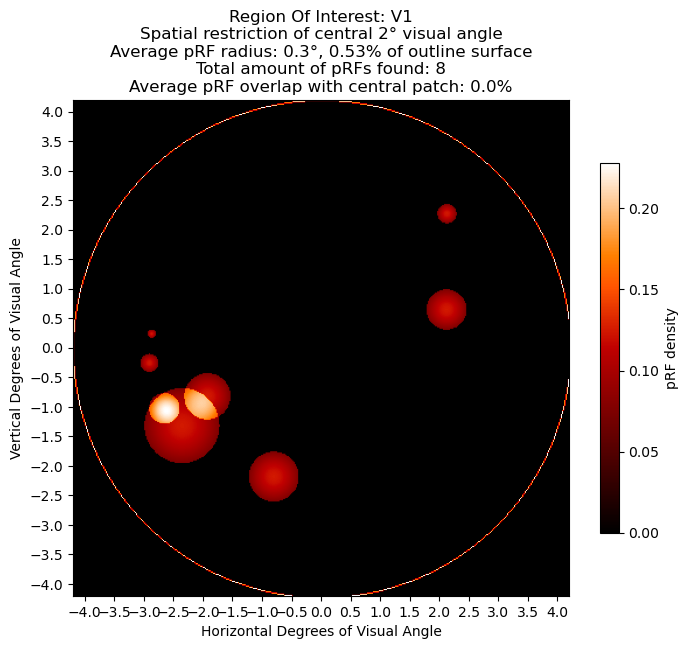

Runtime: 12.976 seconds
There were 1 out of 7887 pRFs considered


In [25]:
start = time.time()

heatmap,iter,end_premat,roi,_,_,total_prfs,_,_ = NSP.cortex.prf_heatmap(1, binary_masks=roi_masks, prf_proc_dict=prf_dict,
                                                        mask_type='cut_gaussian', cmap='gist_heat', print_prog='y', 
                                                        roi='V1', sigma_min=0, sigma_max = 4.2, ecc_max = 4.2, subjects='all', 
                                                        outline_degs = 4.2, fill_outline = 'n',
                                                        filter_dict = prf_rsq_dict, ecc_strict = 'y')

end = time.time()
print("Runtime:", np.round(end - start, 3), "seconds")

if end_premat is not True:
    print("There were", iter, "out of", np.sum(roi_masks['subj01'][f'{roi}_mask']), "pRFs considered")

Subject: subj01, Voxel 1 out of 10 found
Subject: subj01, Voxel 2 out of 10 found
Subject: subj01, Voxel 3 out of 10 found
Subject: subj01, Voxel 4 out of 10 found
Subject: subj01, Voxel 5 out of 10 found
Subject: subj01, Voxel 6 out of 10 found
Subject: subj01, Voxel 7 out of 10 found
Subject: subj01, Voxel 8 out of 10 found
Subject: subj01, Voxel 9 out of 10 found
Subject: subj01, Voxel 10 out of 10 found


Currently 10 prfs found
Subject: subj02, Voxel 1 out of 10 found
Subject: subj02, Voxel 2 out of 10 found
Subject: subj02, Voxel 3 out of 10 found
Subject: subj02, Voxel 4 out of 10 found
Subject: subj02, Voxel 5 out of 10 found
Subject: subj02, Voxel 6 out of 10 found
Subject: subj02, Voxel 7 out of 10 found
Subject: subj02, Voxel 8 out of 10 found
Subject: subj02, Voxel 9 out of 10 found
Subject: subj02, Voxel 10 out of 10 found


Currently 20 prfs found
Subject: subj03, Voxel 1 out of 10 found
Subject: subj03, Voxel 2 out of 10 found
Subject: subj03, Voxel 3 out of 10 found
Sub

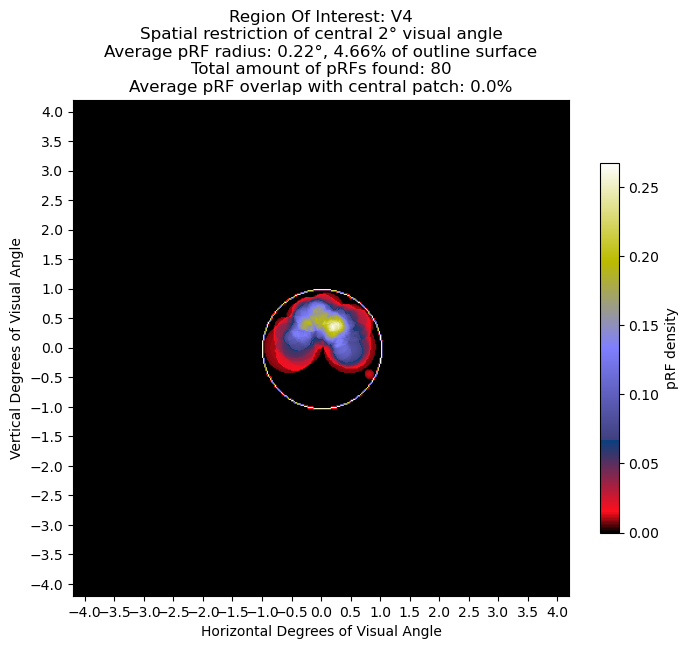

Runtime: 124.022 seconds
There were <built-in function iter> out of 3976 pRFs considered


In [18]:

start = time.time()
# heatmap, iter, end_premat, roi, prf_sizes, avg_surf, total_prfs, prfmask_dict, prf_overlaps
end_premat = NSP.cortex.prf_heatmap(10, binary_masks=roi_masks, prf_proc_dict=prf_dict,
                                                        mask_type='cut_gaussian', cmap='gist_stern', print_prog='y', 
                                                        roi='V4', sigma_min=0, sigma_max = 1, ecc_max = 1, subjects='all', 
                                                        outline_degs = 1, 
                                                        filter_dict = nsd_rsq_dict, ecc_strict = 'y')[2]

end = time.time()
print("Runtime:", np.round(end - start, 3), "seconds")

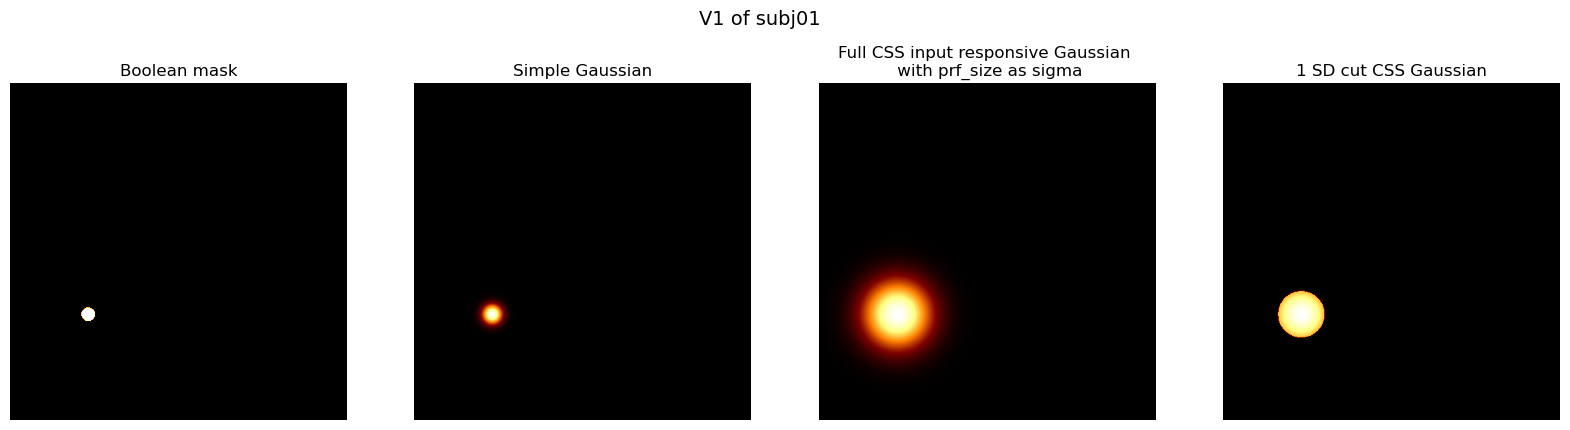

In [65]:
NSP.explore.compare_masks(roi_masks, prf_dict)

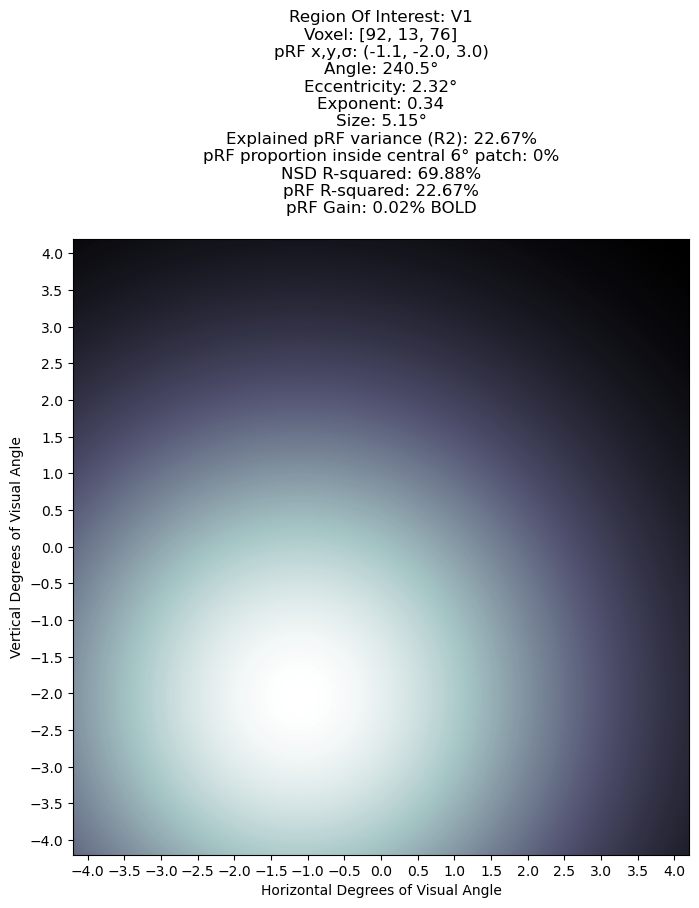

In [47]:
out = NSP.cortex.get_mask(dim = 425, subject = 'subj01', binary_masks = roi_masks, 
                                        prf_proc_dict = prf_dict, type='gaussian', roi='V1',
                                        plot = 'y', excl_reason = 'n', sigma_min=2.9, sigma_max = 3,
                                        ecc_min = 2, ecc_max = 3,
                                        angle_min = 0, angle_max = 360)

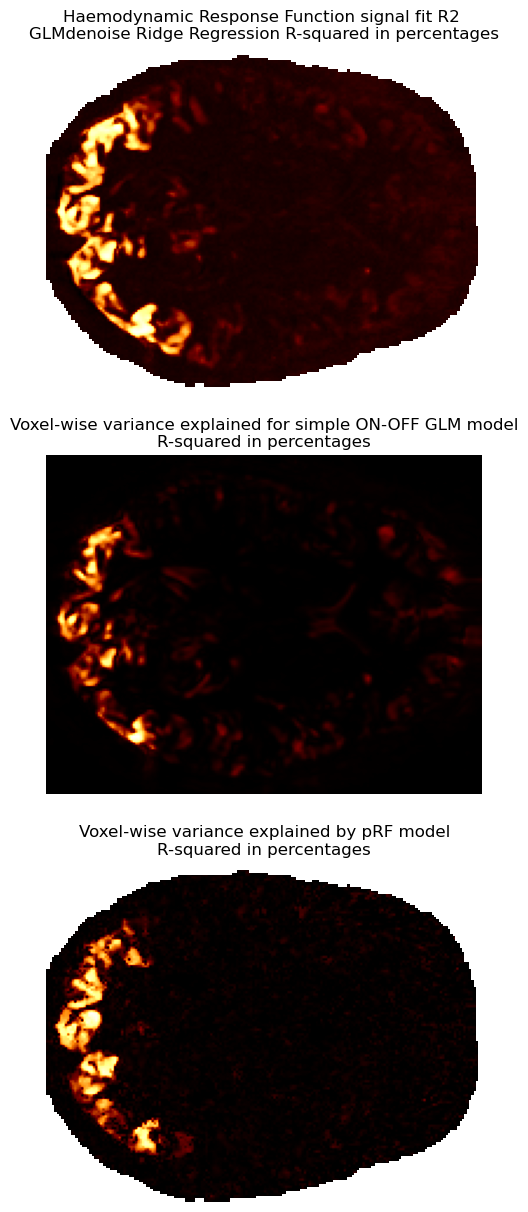

In [44]:
NSP.explore.compare_NSD_R2s(roi_masks, prf_dict, 'subj01', 76)

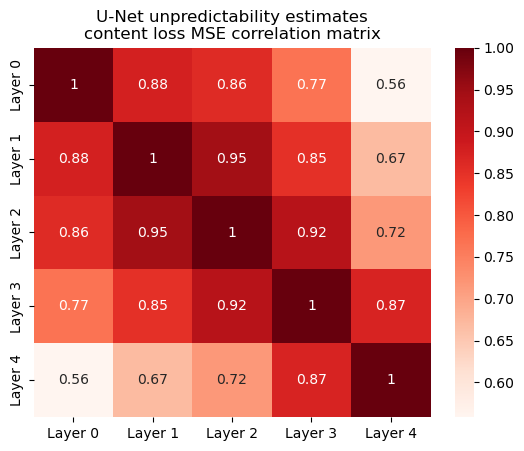

In [67]:
NSP.stimuli.unpred_corrmatrix(type='content', loss_calc='MSE', cmap='Reds')

In [81]:
# Be aware that the layer number here is 1 more than the ones of the 'alex_layn.npy' files, because there I do not include the input layer
# so alex_lay0 corresponds with layer1 here.
img_ids, dataset, pca, feature, lay, layname = NSP.stimuli.extract_features(subject='subj01', layer=12,
                                                     start_img=80, n_imgs=2, batch_size=2, pca_components=2,
                                                     verbose=True, img_crop=True)

/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['input', 'Conv2d_1', 'ReLU_1', 'MaxPool2d_1', 'Conv2d_2', 'ReLU_2', 'MaxPool2d_2', 'Conv2d_3', 'ReLU_3', 'Conv2d_4', 'ReLU_4', 'Conv2d_5', 'ReLU_5', 'MaxPool2d_3', 'Dropout_1', 'Linear_1', 'ReLU_6', 'Dropout_2', 'Linear_2', 'ReLU_7', 'Linear_3']
['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


100%|██████████| 1/1 [00:00<00:00, 15.97it/s]


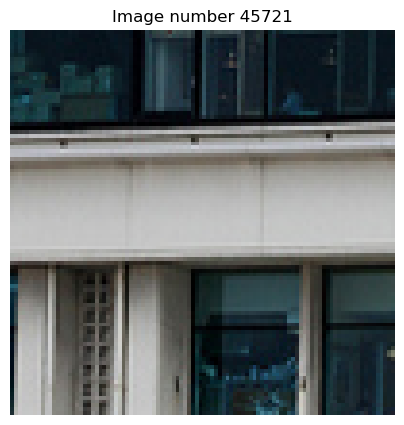

In [79]:
_ = NSP.stimuli.show_stim(img_no=img_ids[0], small=True, crop=True)

ReLU_5


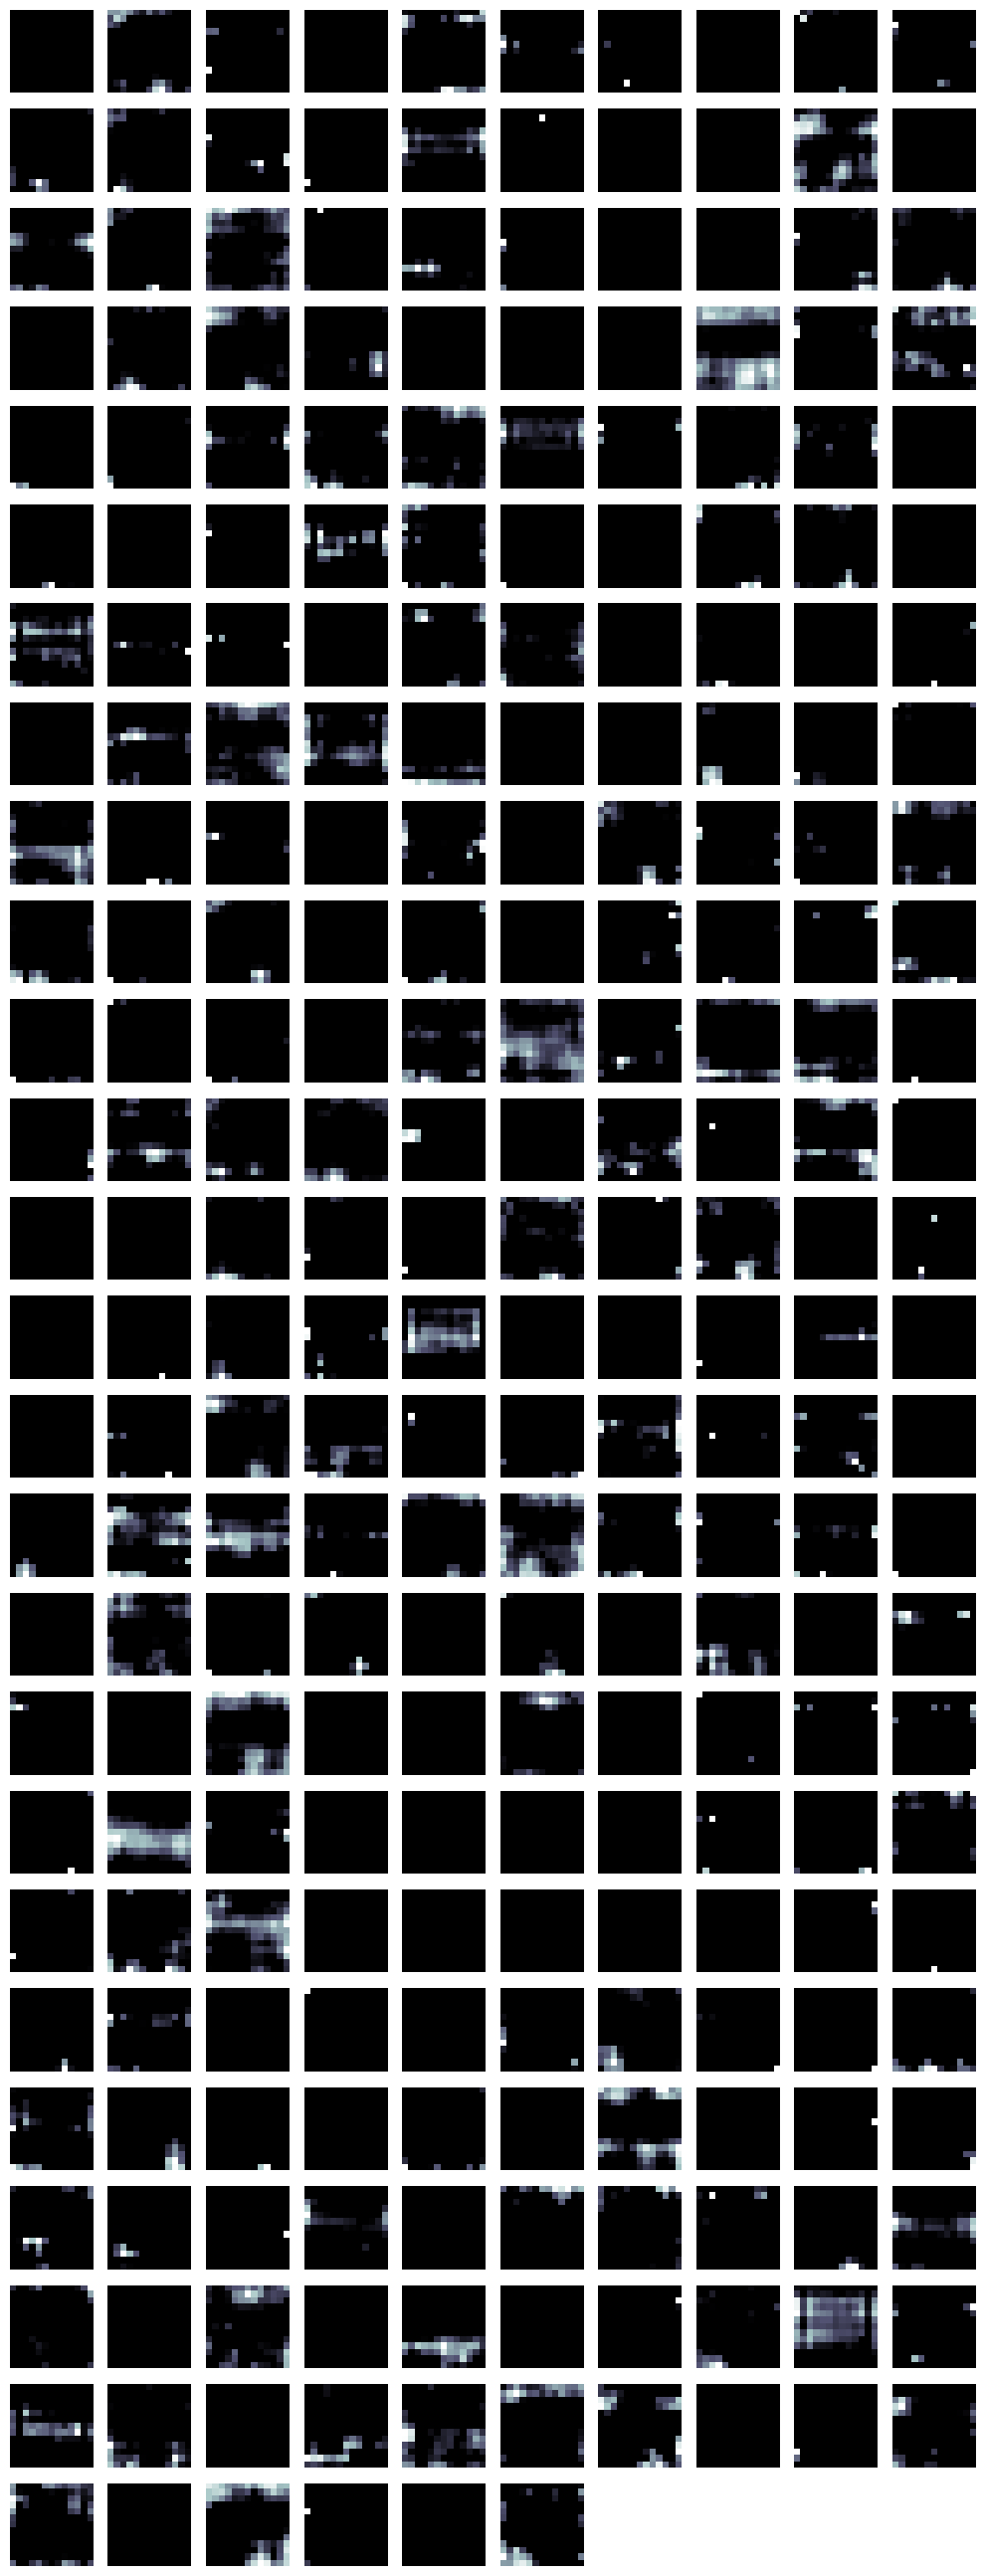

In [82]:
# Plot the feature maps
print(layname)
NSP.stimuli.plot_features(which_img=0, layer=lay, layer_type=layname, img_ids=img_ids, features=feature, num_cols=10, random_cmap=False)

In [35]:
# rois, roi_masks = NSP.visrois_dict()
# prf_dict = NSP.prf_dict(rois, roi_masks)

anats = NSP.anat_templates(prf_dict)

In [37]:
del rois, roi_masks, prf_dict, anats

In [26]:
import psutil
import os
# del NSP
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Memory usage: {process.memory_info().rss / 1024 ** 2} MB")

print_memory_usage()

Memory usage: 5897.66015625 MB


In [11]:
def print_user_variables():
    print("\n".join("%s: %s" % item for item in globals().items() if not item[0].startswith("__")))

print_user_variables()

_ih: ['', 'class DataFetch():\n    \n    def __init__(self):\n        pass\n    # Function to get the visual contrast features and predictability estimates\n    # IMPROVE: make sure that it also works for all subjects later on. Take subject arg, clean up paths.\n    def features(self):\n        feature_paths = [\n            \'./data/custom_files/all_visfeats_rms.pkl\',\n            \'./data/custom_files/all_visfeats_rms_crop_prior.pkl\',\n            \'/home/rfpred/data/custom_files/all_visfeats_scce.pkl\',\n            \'/home/rfpred/data/custom_files/all_visfeats_scce_large.pkl\',\n            \'/home/rfpred/data/custom_files/subj01/pred/all_predestims.h5\'\n        ]\n        return {os.path.basename(file): self._fetch_file(file) for file in feature_paths}\n    # Function to get the pRF-based voxel selections\n    # IMPROVE: make sure that it also works for all subjects later on. Take subject arg, clean up paths.\n    def prf_selections(self):\n        prf_selection_paths = [\n    

In [42]:
import psutil
import os

def print_cpu_usage():
    process = psutil.Process(os.getpid())
    print(f"CPU usage: {process.cpu_percent()}%")

print_cpu_usage()

CPU usage: 0.0%


In [32]:
import sys

x = "Hello, world!"
print(f"Memory usage of x: {sys.getsizeof(heatmap)} bytes")

def inbytes(x):
    return sys.getsizeof(x)


Memory usage of x: 1445128 bytes


180625

In [ ]:
torch.cuda.empty_cace()

In [ ]:
# AlexNet(
#   (features): Sequential(
#     (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
#     (1): ReLU(inplace=True)
#     (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
#     (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
#     (4): ReLU(inplace=True)
#     (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
#     (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#     (7): ReLU(inplace=True)
#     (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#     (9): ReLU(inplace=True)
#     (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#     (11): ReLU(inplace=True)
#     (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
#   )
#   (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
#   (classifier): Sequential(
#     (0): Dropout(p=0.5, inplace=False)
#     (1): Linear(in_features=9216, out_features=4096, bias=True)
#     (2): ReLU(inplace=True)
#     (3): Dropout(p=0.5, inplace=False)
#     (4): Linear(in_features=4096, out_features=4096, bias=True)
#     (5): ReLU(inplace=True)
#     (6): Linear(in_features=4096, out_features=1000, bias=True)
#   )
# )